In [1]:
#!pip install scikit-optimize
#!pip install scikit-learn-intelex
!pip install flaml
!pip install lightgbm

     |████████████████████████████████| 137 kB 24.7 MB/s eta 0:00:01
     |████████████████████████████████| 23.2 MB 736 kB/s  eta 0:00:01
     |████████████████████████████████| 157.5 MB 86 kB/s s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.1
    Uninstalling scikit-learn-0.23.1:
      Successfully uninstalled scikit-learn-0.23.1
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.4.0
    Uninstalling xgboost-1.4.0:
      Successfully uninstalled xgboost-1.4.0


In [2]:
!nvidia-smi

Tue Dec  7 21:54:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     Off  | 00000000:00:05.0 Off |                  N/A |
| 30%   37C    P8     9W / 125W |      0MiB /  7982MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn.metrics import r2_score,accuracy_score, confusion_matrix, classification_report,precision_recall_fscore_support
import numpy as np
import pandas as pd
import sklearn
from flaml import AutoML

#from skopt import BayesSearchCV

import dask_ml.model_selection as dcv
import dask.dataframe as dd
from dask_ml.preprocessing import RobustScaler as dask_RobustScaler

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm, CatBoostClassifier
from sklearn.model_selection import RepeatedKFold, cross_val_score
#from cuml.model_selection import train_test_split
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import RobustScaler
from cuml.preprocessing import RobustScaler as cuml_RobustScaler

from bayes_opt import BayesianOptimization

from cuml import preprocessing
import cuml

from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.neighbors import KNeighborsRegressor, KNeighborsClassifier
from cuml.ensemble import RandomForestRegressor as curfc

from sklearn.decomposition import PCA

cuml.set_global_output_type('numpy')
import cudf
import numpy as np
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

import cupy
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 22})

import seaborn as sns


In [4]:
# Function to compute metric scores for classification tasks
def metric_scores(x,y):
    print('Classification report: \n', classification_report(x, y, digits=5))
    print('\n Confusion matrix: \n', confusion_matrix(x,y))

# Function to plot feature importances
def plot_feature_importance(importance,names,model_type, file_name):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(8,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:20], y=fi_df['feature_names'][:20])
    plt.xscale('log')
    #Add chart labels
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.savefig('./fig/'+ str(file_name),bbox_inches='tight')
    
def create_rgr_plot(df, y_test, z_pred, title, file_name):
    # Plot predictions vs ground-truth
    cmap='Paired'
    plt.figure()
    a=plt.scatter(y_test, pd.Series(z_pred), c=df['class'],
             cmap=cmap,
            #edgecolors=(0, 0, 0),
            s=20, alpha = 1)
    plt.plot([y_test.min(),y_test.max()], [y_test.min(),y_test.max()], 'k--', lw=2)
    plt.plot(y_test, (y_test-0.15)/1.15, '-.k', lw=2)
    plt.plot(y_test, (y_test+0.15)/0.85, '-.k', lw=2)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(handles=a.legend_elements()[0], labels=['GALAXY','QSO','STAR'])
    plt.xlabel('1+z, Measured', fontsize=28)
    plt.ylabel('1+z, Predicted', fontsize=28)
    plt.title( title, fontsize=22)
    plt.savefig('./fig/'+ str(file_name),bbox_inches='tight')

    return plt

# Function to compute model predictions and features importances
def ml_model(model, X_train, y_train, X_test, y_test, var):
    try:
        model.fit(X_train.astype(np.float32),y_train[var])
        pred = model.predict(X_test.astype(np.float32))
        pred_proba = model.predict_proba(X_test.astype(np.float32))
        test_y = y_test[var].reset_index(drop=True)
        # define evaluation procedure
        #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
        # evaluate model
        #scores = cross_val_score(model, X_test, y_test[var], scoring='f1', cv=cv, n_jobs=-1)
        # summarize performance
        #print('Mean F1-Score: %.5f' % mean(scores))
        print(metric_scores(test_y,pred))
    except:
        
        model.fit(X_train.to_pandas().astype(np.float32),y_train[var].to_pandas())
        pred = model.predict(X_test.to_pandas().astype(np.float32))
        pred_proba = model.predict_proba(X_test.to_pandas().astype(np.float32))
        test_y = y_test[var].to_pandas().reset_index(drop=True)
        print(metric_scores(test_y,pred))
    pass
    
    try:
        features_importances = model.feature_importances_
    except:
        features_importances = []

    return pred, pred_proba, features_importances

# Function to flag objects with outliers photomotric redshifts
def flag_cat_outliers(x, var1, var2):
    # x (DataFrame): Data to verify outliers
    # var1 (string): ground-truth variable
    # var2 (string): predicted variable
    met = np.abs(pd.Series(x[var2]-x[var1]))
    f_out = met/(1+x[var1].astype(np.float32))
    y_outlier = pd.Series(np.where(f_out > 0.15, 0, 1)).reindex(x.index)
    return y_outlier

In [5]:
def act_learn_outlier(model,x_train, y_train, x_test, y_test):
    # ML model to detect
    model.fit(x_train, y_train['flag_outlier'])
    print('Outlier model fit done!')
    outliers = pd.DataFrame(model.predict(x_test), index=x_test.index, columns=['flag'])
    print(metric_scores(y_test['flag_outlier'],outliers['flag']))
    print('Outlier predictions completed!')
    indices = outliers[outliers['flag']==0].index.to_list()
    x_test = x_test.drop(indices)
    y_test = y_test.drop(indices)
    print('Potential catastrophic outliers exterminated!')
    return x_test, y_test

def clf_act_learn (model_clf, model_out,df, features, targets):
    X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[targets], 
                                                    test_size=0.3, 
                                                    shuffle =True, 
                                                    random_state=0)
    print('Train Test Split finished.')
    model_clf.fit(X_train.astype(np.float32),y_train['class'].astype(np.int32))
    print('Model fit done!')
    pred = model_clf.predict(X_test.astype(np.float32))
    print('Model predictions completed!')
    test_y = y_test['class'].reset_index(drop=True)
    print(metric_scores(test_y,pred))
    
    print('Active learning mode activated!')
    X_test_al, y_test_al = act_learn_outlier(model_out,X_train, y_train, X_test, y_test)
    print('Active learning mode completed!')
    new_pred = model_clf.predict(X_test_al.astype(np.float32))
    print('New predictions!')
    y_test_al = y_test_al['class'].reset_index(drop=True)
    print(metric_scores(y_test_al,new_pred))
    
    return X_train, X_test, y_train, y_test, pred, new_pred, X_test_al, y_test_al

def bayes_opt_model(model,X_train, y_train, y_test):
    # model (sklearn, xgb, etc): model to optimize
    # X_train (DataFrame): Data for training
    # y_train (Series): Data to predict. IMPORTANT: Specify the variable to target
    params = {'n_estimators': [1000,2000],
          'max_depth': [1, 12],
         'learning_rate': [0.1,1]}

    opt = BayesSearchCV(
        model,
        params,
        n_iter=30,
        cv=3
    )

    opt.fit(X_train, y_train)

    print("val. score: %s" % opt.best_score_)
    print("test score: %s" % opt.score(X_test, y_test))
    
    return opt.best_estimator_

def kf_oof(clf,X_train,y_train,X_test, var,nkf):

    kf= RepeatedKFold(n_splits=5,random_state=42)
    kf.get_n_splits(features)

    oof_predictions = np.zeros(len(X_train))
    oof_test_predictions = np.zeros(len(X_test))
    i=0
    
    for train_index, holdout_index in kf.split(X_train, y_train[var]):
        i+=1

        clf.fit(X_train.iloc[train_index], y_train[var].iloc[train_index])
    
        y_pred = clf.predict(X_train.iloc[holdout_index])
        oof_predictions[holdout_index] = y_pred
    
        y_test_pred = clf.predict(X_test)
        oof_test_predictions += y_test_pred
        print("For cycle loop:",i)
        

    oof_test_predictions = oof_test_predictions/i
    return oof_predictions, oof_test_predictions

In [6]:
def create_colours(data, features):
    """Create dataframe with colour-colour data. Return an Array and list of colours.

    Args:
        data (DataFrame): Dataframe with photometric data
        features (list): List of features from photometric data
    """
    N = len(data)
    F = len(features)
    n=0
    for i in np.linspace(1,F,F,dtype=int):
    	n = n + (i-1)

    df_features = np.zeros((N, n))
    y=0
    lista=[]
    for z in np.linspace(0,F,F,dtype=int):
        for x in np.linspace(1,F-1,F-1,dtype=int):
            if z!=x and z<x:
                df_features[:,y] = np.abs(data[features[z]] - data[features[x]])
                y+=1
                lista += [features[z]+'-'+features[x]]
            else:
                pass
    df_colours = pd.DataFrame(df_features,columns = lista, index = data.index)
    return df_colours

def flaml_opt_clf(estimator, X_train, y_train):
    model = AutoML()
    
    if estimator == ['cb']:
        
        settings = {
        "time_budget": 4200,  # total running time in seconds
        #"metric": 'f1',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
        "estimator_list": ['catboost'],  # list of ML learners; we tune xgboost in this example
        "n_jobs": -1,
        "task": 'classification',  # task type    
        "log_file_name": 'clf.log'  # flaml log file
        }
    
    
    elif estimator == ['xgb']:
        
        settings = {
        "time_budget": 4200,  # total running time in seconds
        #"metric": 'f1',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
        "estimator_list": ['xgboost'],  # list of ML learners; we tune xgboost in this example
        "n_jobs": -1,
        #"average": 'macro',
        #"tree_method":'gpu_hist',
        "task": 'classification',  # task type    
        "log_file_name": 'clf.log'  # flaml log file
        }
        
    elif estimator == ['lgb']:
        
        settings = {
        "time_budget": 4200,  # total running time in seconds
        #"metric": 'f1',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
        "estimator_list": ['lgbm'],  # list of ML learners; we tune xgboost in this example
        "n_jobs": -1,
        "task": 'classification',  # task type    
        "log_file_name": 'clf.log'  # flaml log file
        }
    else:
        settings = {
        "time_budget": 4200,  # total running time in seconds
        #"metric": 'f1',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
        "n_jobs": -1,
        "task": 'classification',  # task type    
        "log_file_name": 'clf.log'  # flaml log file
        }
        
        
    model.fit(X_train=X_train, y_train=y_train, **settings)

    print('Best estimator:', model.best_config_per_estimator)
    return model

# Data 

In [7]:
df = pd.read_pickle('./Data/SDSS_DR15_final.pkl')

In [8]:
df = df.drop('ra',axis=1)
df = df.drop('dec',axis=1)

df_coords = cudf.read_csv('./Data/SDSS_DR15_coords_PCunha.csv')
df_coords = df_coords[['specObjID','ra','dec']]

df = cudf.DataFrame.from_pandas(df)
df = cudf.merge(df,df_coords,on='specObjID', how='inner')

df = df.to_pandas()

In [9]:
len(df)

3497864

In [10]:
df.columns.to_list()

['specObjID',
 'psfMag_u',
 'psfMag_g',
 'psfMag_r',
 'psfMag_i',
 'psfMag_z',
 'w1mpro',
 'w2mpro',
 'w3mpro',
 'w4mpro',
 'z',
 'class',
 'modelMag_u',
 'modelMag_g',
 'modelMag_r',
 'modelMag_i',
 'modelMag_z',
 'petroMag_u',
 'petroMag_g',
 'petroMag_r',
 'petroMag_i',
 'petroMag_z',
 'cModelMag_u',
 'cModelMag_g',
 'cModelMag_r',
 'cModelMag_i',
 'cModelMag_z',
 'mjd',
 'plate',
 'fiberID',
 'cModelMag_u-cModelMag_g',
 'cModelMag_u-cModelMag_r',
 'cModelMag_u-cModelMag_i',
 'cModelMag_u-cModelMag_z',
 'cModelMag_g-cModelMag_r',
 'cModelMag_g-cModelMag_i',
 'cModelMag_g-cModelMag_z',
 'cModelMag_r-cModelMag_i',
 'cModelMag_r-cModelMag_z',
 'cModelMag_i-cModelMag_z',
 'modelMag_u-modelMag_g',
 'modelMag_u-modelMag_r',
 'modelMag_u-modelMag_i',
 'modelMag_u-modelMag_z',
 'modelMag_g-modelMag_r',
 'modelMag_g-modelMag_i',
 'modelMag_g-modelMag_z',
 'modelMag_r-modelMag_i',
 'modelMag_r-modelMag_z',
 'modelMag_i-modelMag_z',
 'psfMag_u-cModelMag_u',
 'psfMag_g-cModelMag_g',
 'psfMag_r-

In [11]:
!pip install astropy

     |████████████████████████████████| 10.7 MB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 746 kB 53.5 MB/s eta 0:00:01


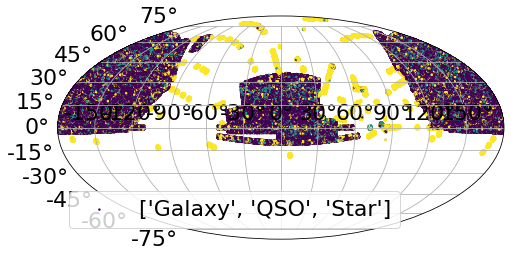

In [17]:
import astropy.coordinates as coord
import astropy.units as u

ra = coord.Angle(df['ra']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(df['dec']*u.degree)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian, c=df['class'], cmap=cm.viridis, s=2)
#ax.legend()
ax.grid(True)
fig.savefig("./fig/map.pdf")

<module 'matplotlib.pyplot' from '/opt/conda/envs/rapids/lib/python3.7/site-packages/matplotlib/pyplot.py'>

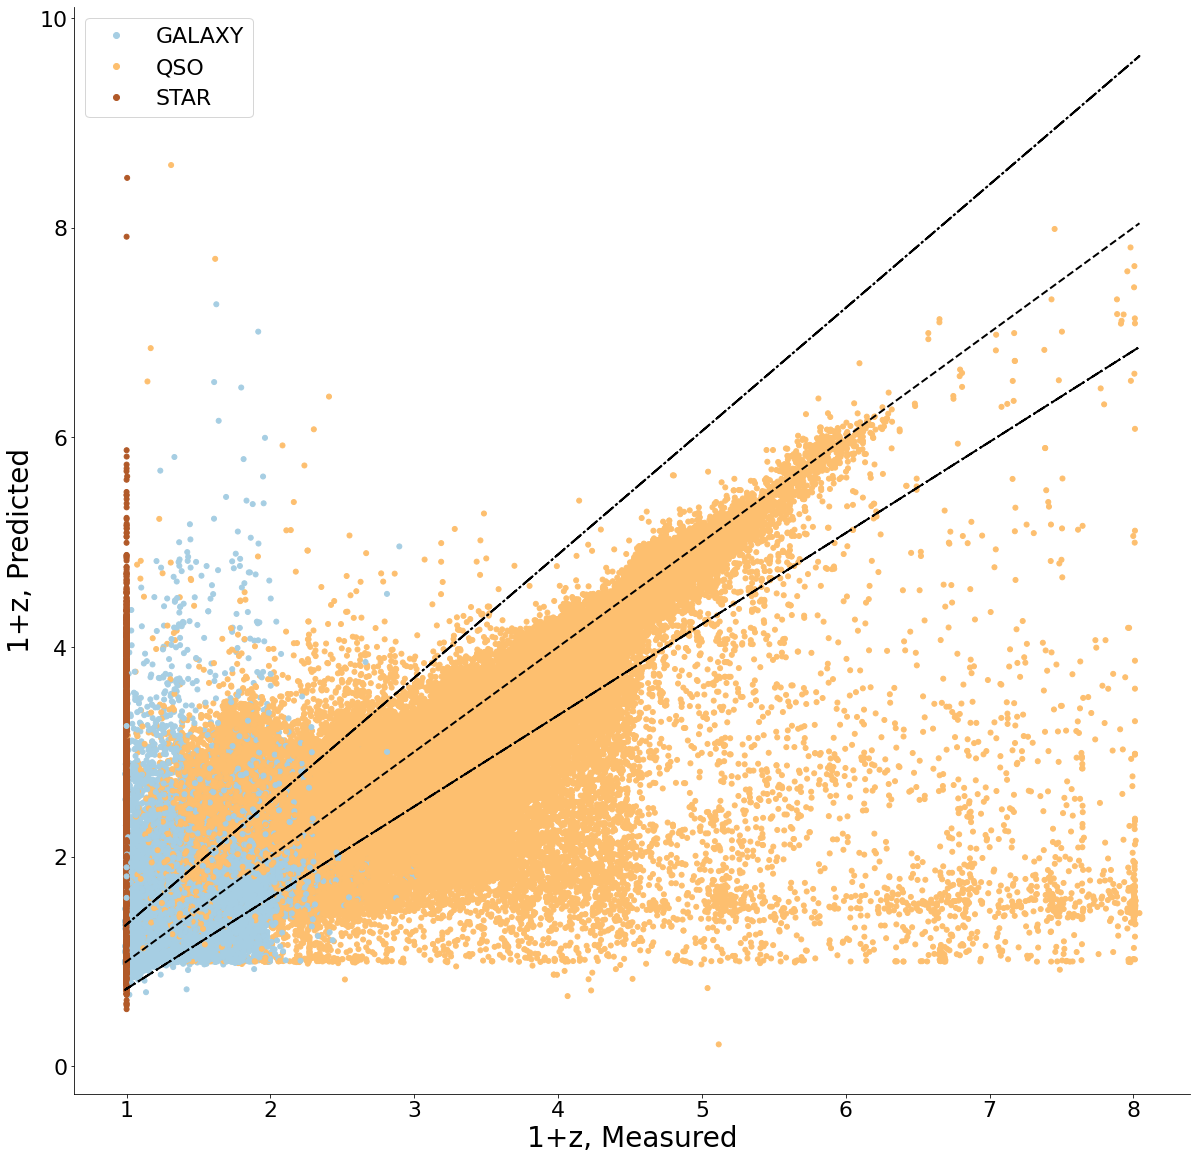

In [38]:
create_rgr_plot(df,df['z'], df['imp_z'], '', 'plot_phot_z.png')

In [11]:
df

,specObjID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,w1mpro,w2mpro,w3mpro,w4mpro,...,w1mpro-w3mpro,w1mpro-w4mpro,w2mpro-w3mpro,w2mpro-w4mpro,w3mpro-w4mpro,w1-w2-w3,w1-w2-w3-w4,imp_z,flag_outlier,oof_flag_outlier
0,299489676975171584,19.086210,17.417789,16.595810,16.034969,15.680770,11.856000,11.872,9.154,7.836,...,2.702,4.020,2.718,4.036,1.318,9.170,17.006001,1.031694,0.0,0.0
1,299489677444933632,19.086210,17.417789,16.595810,16.034969,15.680770,11.856000,11.872,9.154,7.836,...,2.702,4.020,2.718,4.036,1.318,9.170,17.006001,1.033450,0.0,0.0
2,299489951853078528,22.678499,20.570419,19.164761,18.745230,18.312450,14.574000,14.207,11.902,8.626,...,2.672,5.948,2.305,5.581,3.276,11.535,20.160999,1.210131,0.0,0.0
3,299489952322840576,22.343210,20.316629,18.933720,18.372570,17.988461,14.226000,13.918,12.521,9.106,...,1.705,5.120,1.397,4.812,3.415,12.213,21.319000,1.213816,0.0,0.0
4,299490226730985472,20.024401,19.601589,19.492901,19.371880,19.298290,15.102000,14.071,11.880,8.372,...,3.222,6.730,2.191,5.699,3.508,10.849,19.221001,1.659689,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474913,11259270496166846464,23.912531,23.555460,22.746799,21.878040,20.049231,15.729000,15.002,11.273,8.584,...,4.456,7.145,3.729,6.418,2.689,10.546,19.129999,2.044420,0.0,0.0
3474914,11259270771044753408,19.719530,19.538170,19.356890,18.952471,18.992161,15.687000,14.676,11.301,8.737,...,4.386,6.950,3.375,5.939,2.564,10.290,19.027000,2.857131,0.0,0.0
3474915,11259271045922660352,26.007179,23.568859,22.621071,21.113041,20.064899,16.054001,15.412,11.976,7.921,...,4.078,8.133,3.436,7.491,4.055,11.334,19.254999,1.938109,0.0,0.0
3474916,11259271320800567296,24.128031,22.385111,21.015579,20.358210,19.912359,16.104000,15.665,12.139,8.793,...,3.965,7.311,3.526,6.872,3.346,11.700,20.493000,1.417181,0.0,0.0


In [12]:
df['specObjID'].is_unique

True

In [13]:
len(df[df.duplicated(['specObjID'])])

0

In [ ]:
# Add specObjID for identification and addition of 2MASS and FIRST data
df_psf = pd.read_csv('./Data/SDSS_DR15_zspec.csv')
df_psf = df_psf['specObjID']

df['specObjID'] = df_psf

df_add = pd.read_csv('./Data/SDSS_DR15_phot_2MASS_first_PCunha.csv')
list_add = ['specObjID','j', 'h', 'k','first_peak', 'first_integrated']
df_add = df_add[list_add]


df_check_2MASS_FIRST = pd.merge(df, df_add, on='specObjID', how='outer')

In [ ]:
#df_imp_z = pd.read_csv('./Data/z_spec_pred_v3(xbg_cb_lgb).csv')
#df_imp_z.columns=['index','imp_z']
#df_imp_z.set_index('index', inplace=True)
#df_imp_z = df_imp_z.sort_index()

#df = df.sort_index()

#df = pd.concat([df,df_imp_z], axis=1, sort=False)

## Train Test Split

In [11]:
features = df.columns.to_list()
features.remove('specObjID')
features.remove('class')
features.remove('z')
features.remove('flag_outlier')
features.remove('ra')
features.remove('dec')
features.remove('mjd')
features.remove('plate')
features.remove('fiberID')

targets = ['class']

In [12]:
features

['psfMag_u',
 'psfMag_g',
 'psfMag_r',
 'psfMag_i',
 'psfMag_z',
 'w1mpro',
 'w2mpro',
 'w3mpro',
 'w4mpro',
 'modelMag_u',
 'modelMag_g',
 'modelMag_r',
 'modelMag_i',
 'modelMag_z',
 'petroMag_u',
 'petroMag_g',
 'petroMag_r',
 'petroMag_i',
 'petroMag_z',
 'cModelMag_u',
 'cModelMag_g',
 'cModelMag_r',
 'cModelMag_i',
 'cModelMag_z',
 'cModelMag_u-cModelMag_g',
 'cModelMag_u-cModelMag_r',
 'cModelMag_u-cModelMag_i',
 'cModelMag_u-cModelMag_z',
 'cModelMag_g-cModelMag_r',
 'cModelMag_g-cModelMag_i',
 'cModelMag_g-cModelMag_z',
 'cModelMag_r-cModelMag_i',
 'cModelMag_r-cModelMag_z',
 'cModelMag_i-cModelMag_z',
 'modelMag_u-modelMag_g',
 'modelMag_u-modelMag_r',
 'modelMag_u-modelMag_i',
 'modelMag_u-modelMag_z',
 'modelMag_g-modelMag_r',
 'modelMag_g-modelMag_i',
 'modelMag_g-modelMag_z',
 'modelMag_r-modelMag_i',
 'modelMag_r-modelMag_z',
 'modelMag_i-modelMag_z',
 'psfMag_u-cModelMag_u',
 'psfMag_g-cModelMag_g',
 'psfMag_r-cModelMag_r',
 'psfMag_i-cModelMag_i',
 'psfMag_z-cModelMag_

In [13]:
# Train Test Spit Data with 0.5 as in Clarke et al
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[targets], 
                                                    test_size=0.5, 
                                                    shuffle =True, 
                                                    random_state=0)

# Models

## Multiclass approach

In [15]:
xgb_clf = flaml_opt_clf(['xgb'], X_train, y_train['class'])

[flaml.automl: 12-02 15:40:33] {1926} INFO - task = classification
[flaml.automl: 12-02 15:40:33] {1928} INFO - Data split method: stratified
[flaml.automl: 12-02 15:40:33] {1932} INFO - Evaluation method: holdout
[flaml.automl: 12-02 15:40:43] {1999} INFO - Minimizing error metric: log_loss
[flaml.automl: 12-02 15:40:43] {2051} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl: 12-02 15:40:43] {2291} INFO - iteration 0, current learner xgboost
[flaml.automl: 12-02 15:40:43] {2405} INFO - Estimated sufficient time budget=494952s. Estimated necessary time budget=495s.
[flaml.automl: 12-02 15:40:43] {2485} INFO -  at 121.8s,	estimator xgboost's best error=0.6826,	best estimator xgboost's best error=0.6826
[flaml.automl: 12-02 15:40:43] {2291} INFO - iteration 1, current learner xgboost
[flaml.automl: 12-02 15:40:43] {2485} INFO -  at 122.1s,	estimator xgboost's best error=0.6826,	best estimator xgboost's best error=0.6826
[flaml.automl: 12-02 15:40:43] {2291} INFO - ite

[flaml.automl: 12-02 15:54:16] {2291} INFO - iteration 35, current learner xgboost
[flaml.automl: 12-02 15:58:44] {2485} INFO -  at 1202.3s,	estimator xgboost's best error=0.0438,	best estimator xgboost's best error=0.0438
[flaml.automl: 12-02 15:58:44] {2291} INFO - iteration 36, current learner xgboost
[flaml.automl: 12-02 16:00:59] {2485} INFO -  at 1337.6s,	estimator xgboost's best error=0.0438,	best estimator xgboost's best error=0.0438
[flaml.automl: 12-02 16:00:59] {2291} INFO - iteration 37, current learner xgboost
[flaml.automl: 12-02 16:16:05] {2485} INFO -  at 2243.2s,	estimator xgboost's best error=0.0438,	best estimator xgboost's best error=0.0438
[flaml.automl: 12-02 16:16:05] {2291} INFO - iteration 38, current learner xgboost
[flaml.automl: 12-02 16:16:41] {2485} INFO -  at 2279.9s,	estimator xgboost's best error=0.0438,	best estimator xgboost's best error=0.0438
[flaml.automl: 12-02 16:16:41] {2291} INFO - iteration 39, current learner xgboost
[flaml.automl: 12-02 16:2

Best estimator: {'xgboost': {'n_estimators': 150, 'max_leaves': 605, 'min_child_weight': 45.13563288392657, 'learning_rate': 0.07438542233856403, 'subsample': 0.8977673953174077, 'colsample_bylevel': 0.5241738682334621, 'colsample_bytree': 0.671168787703373, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.6112274550663784, 'FLAML_sample_size': 1563713}}


In [43]:
cb_clf = flaml_opt_clf(['cb'], X_train, y_train['class'])

[flaml.automl: 12-02 22:39:46] {1926} INFO - task = classification
[flaml.automl: 12-02 22:39:46] {1928} INFO - Data split method: stratified
[flaml.automl: 12-02 22:39:46] {1932} INFO - Evaluation method: holdout
[flaml.automl: 12-02 22:39:56] {1999} INFO - Minimizing error metric: log_loss
[flaml.automl: 12-02 22:39:56] {2051} INFO - List of ML learners in AutoML Run: ['catboost']
[flaml.automl: 12-02 22:39:56] {2291} INFO - iteration 0, current learner catboost
[flaml.automl: 12-02 22:40:00] {2405} INFO - Estimated sufficient time budget=6323491s. Estimated necessary time budget=6323s.
[flaml.automl: 12-02 22:40:00] {2485} INFO -  at 123.7s,	estimator catboost's best error=0.0648,	best estimator catboost's best error=0.0648
[flaml.automl: 12-02 22:40:00] {2291} INFO - iteration 1, current learner catboost
[flaml.automl: 12-02 22:40:14] {2485} INFO -  at 137.6s,	estimator catboost's best error=0.0648,	best estimator catboost's best error=0.0648
[flaml.automl: 12-02 22:40:14] {2291} I

Best estimator: {'catboost': {'early_stopping_rounds': 11, 'learning_rate': 0.18865783582261322, 'n_estimators': 131, 'FLAML_sample_size': 1563713}}


In [44]:
lgb_clf = flaml_opt_clf(['lgb'], X_train, y_train['class'])

[flaml.automl: 12-02 23:50:56] {1926} INFO - task = classification
[flaml.automl: 12-02 23:50:56] {1928} INFO - Data split method: stratified
[flaml.automl: 12-02 23:50:56] {1932} INFO - Evaluation method: holdout
[flaml.automl: 12-02 23:51:05] {1999} INFO - Minimizing error metric: log_loss
[flaml.automl: 12-02 23:51:05] {2051} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 12-02 23:51:06] {2291} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-02 23:51:06] {2405} INFO - Estimated sufficient time budget=416766s. Estimated necessary time budget=417s.
[flaml.automl: 12-02 23:51:06] {2485} INFO -  at 115.3s,	estimator lgbm's best error=0.4140,	best estimator lgbm's best error=0.4140
[flaml.automl: 12-02 23:51:06] {2291} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-02 23:51:06] {2485} INFO -  at 115.5s,	estimator lgbm's best error=0.4140,	best estimator lgbm's best error=0.4140
[flaml.automl: 12-02 23:51:06] {2291} INFO - iteration 2, current lea

[flaml.automl: 12-02 23:54:49] {2485} INFO -  at 338.9s,	estimator lgbm's best error=0.0479,	best estimator lgbm's best error=0.0479
[flaml.automl: 12-02 23:54:49] {2291} INFO - iteration 37, current learner lgbm
[flaml.automl: 12-02 23:57:35] {2485} INFO -  at 504.5s,	estimator lgbm's best error=0.0452,	best estimator lgbm's best error=0.0452
[flaml.automl: 12-02 23:57:35] {2291} INFO - iteration 38, current learner lgbm
[flaml.automl: 12-03 00:04:29] {2485} INFO -  at 918.5s,	estimator lgbm's best error=0.0448,	best estimator lgbm's best error=0.0448
[flaml.automl: 12-03 00:04:29] {2291} INFO - iteration 39, current learner lgbm
[flaml.automl: 12-03 00:07:52] {2485} INFO -  at 1121.0s,	estimator lgbm's best error=0.0448,	best estimator lgbm's best error=0.0448
[flaml.automl: 12-03 00:07:52] {2291} INFO - iteration 40, current learner lgbm
[flaml.automl: 12-03 00:54:46] {2485} INFO -  at 3935.9s,	estimator lgbm's best error=0.0448,	best estimator lgbm's best error=0.0448
[flaml.automl

Best estimator: {'lgbm': {'n_estimators': 914, 'num_leaves': 26, 'min_child_samples': 9, 'learning_rate': 0.10233023968742658, 'log_max_bin': 10, 'colsample_bytree': 0.9102721130426018, 'reg_alpha': 0.002021902215198225, 'reg_lambda': 22.68747159832061, 'FLAML_sample_size': 1563713}}


In [15]:
xgb_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5241738682334621, colsample_bynode=1,
              colsample_bytree=0.671168787703373, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.07438542233856403,
              max_delta_step=0, max_depth=0, max_leaves=605,
              min_child_weight=45.13563288392657, missing=-9999.0,
              monotone_constraints='()', n_estimators=150, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0.0009765625, reg_lambda=0.6112274550663784,
              scale_pos_weight=None, subsample=0.8977673953174077,
              use_label_encoder=False,validate_parameters=1, verbosity=0,
              tree_method='gpu_hist')

In [16]:
cb_clf = CatBoostClassifier(early_stopping_rounds= 11, learning_rate= 0.18865783582261322,
                            n_estimators= 131,verbose=0, task_type="GPU")

In [17]:
lgb_clf = lgb.LGBMClassifier(colsample_bytree=0.9102721130426018,
               learning_rate=0.10233023968742658, max_bin=1023,
               min_child_samples=9, n_estimators=914, num_leaves=26,
               reg_alpha=0.002021902215198225, reg_lambda=22.68747159832061,
               verbose=-1)

In [18]:
xgb_pred,xgb_pred_proba, xgb_feat_importance = ml_model(xgb_clf, X_train, y_train, X_test, y_test, 'class')

Classification report: 
               precision    recall  f1-score   support

           0    0.98944   0.99494   0.99218   1201108
           1    0.97504   0.95995   0.96744    237005
           2    0.98976   0.97980   0.98476    299346

    accuracy                        0.98756   1737459
   macro avg    0.98475   0.97823   0.98146   1737459
weighted avg    0.98753   0.98756   0.98753   1737459


 Confusion matrix: 
 [[1195030    3985    2093]
 [   8551  227513     941]
 [   4209    1838  293299]]
None


In [19]:
cb_pred, cb_pred_proba,cb_feat_importance = ml_model(cb_clf, X_train, y_train, X_test, y_test, 'class')

Classification report: 
               precision    recall  f1-score   support

           0    0.98815   0.99440   0.99127   1201108
           1    0.97254   0.95653   0.96447    237005
           2    0.98884   0.97665   0.98271    299346

    accuracy                        0.98618   1737459
   macro avg    0.98318   0.97586   0.97948   1737459
weighted avg    0.98614   0.98618   0.98614   1737459


 Confusion matrix: 
 [[1194381    4300    2427]
 [   9431  226702     872]
 [   4887    2102  292357]]
None


In [20]:
lgb_pred, lgb_pred_proba, lgb_feat_importance = ml_model(lgb_clf, X_train, y_train, X_test, y_test, 'class')

Classification report: 
               precision    recall  f1-score   support

           0    0.98941   0.99482   0.99211   1201108
           1    0.97448   0.95963   0.96700    237005
           2    0.98952   0.97974   0.98460    299346

    accuracy                        0.98742   1737459
   macro avg    0.98447   0.97806   0.98124   1737459
weighted avg    0.98739   0.98742   0.98739   1737459


 Confusion matrix: 
 [[1194884    4083    2141]
 [   8601  227438     966]
 [   4192    1873  293281]]
None


In [21]:
multiclass_pred = pd.DataFrame({'xgb': xgb_pred, 'cb': pd.Series(map(lambda x: x[0], cb_pred), index=y_test.index), 'lgb': lgb_pred}, index=y_test.index)

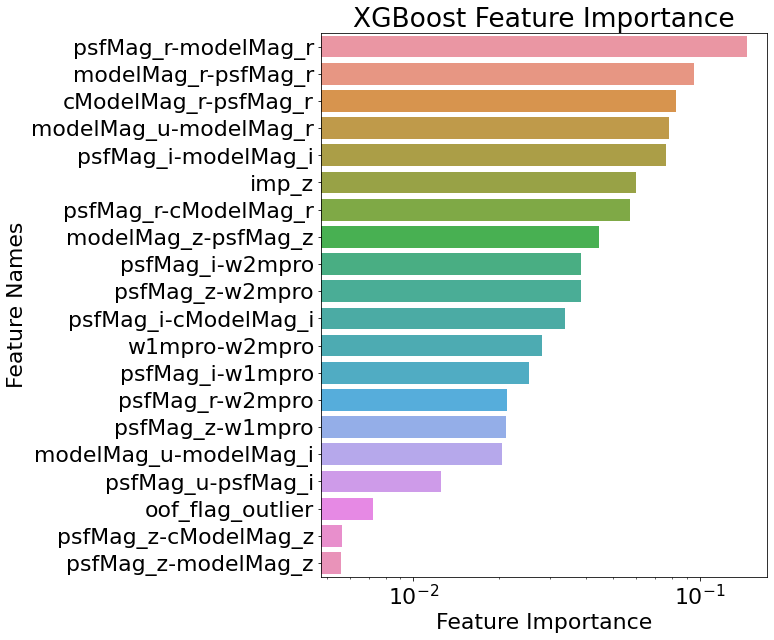

In [22]:
plot_feature_importance(xgb_feat_importance,features,'XGBoost', 'feat_import_xgb_multiclass.png')

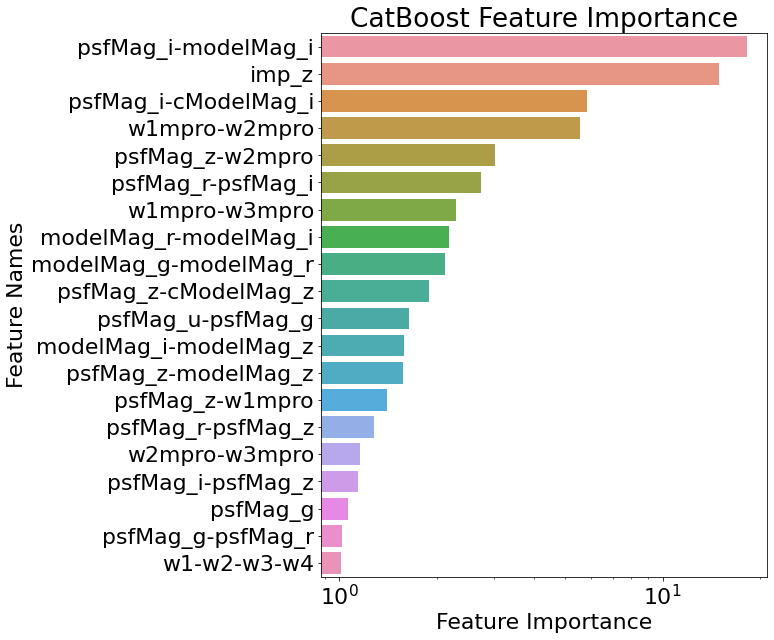

In [23]:
plot_feature_importance(cb_feat_importance,features,'CatBoost', 'feat_import_cb_multiclass.png')

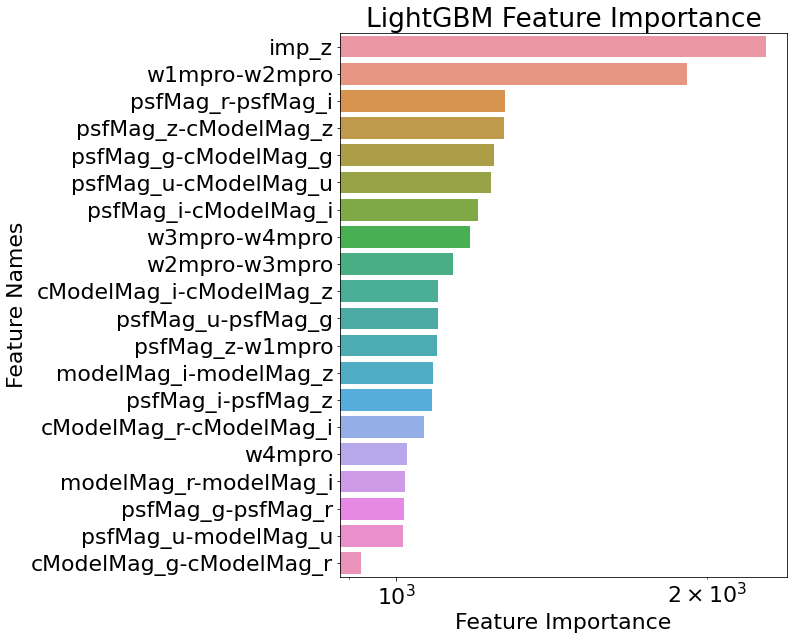

In [24]:
plot_feature_importance(lgb_feat_importance,features,'LightGBM', 'feat_import_lgb_multiclass.png')

In [32]:
multiclass_pred['hard_vote']=np.round(multiclass_pred.mean(axis=1), decimals=0).astype('int32')

In [33]:
multiclass_pred

,xgb,cb,lgb,hard_vote
293641,0,0,0,0
1469694,2,2,2,2
2460413,0,0,0,0
1289899,2,2,2,2
1673560,0,0,0,0
...,...,...,...,...
3187879,1,1,1,1
1371717,2,2,2,2
1608334,0,0,0,0
123670,0,0,0,0


In [34]:
metric_scores(y_test['class'],multiclass_pred['hard_vote'])

Classification report: 
               precision    recall  f1-score   support

           0    0.98975   0.99431   0.99202   1201108
           1    0.96358   0.95993   0.96175    237005
           2    0.99135   0.97599   0.98361    299346

    accuracy                        0.98646   1737459
   macro avg    0.98156   0.97674   0.97913   1737459
weighted avg    0.98645   0.98646   0.98644   1737459


 Confusion matrix: 
 [[1194268    5147    1693]
 [   8639  227509     857]
 [   3735    3453  292158]]


# Active Learning approach

In [10]:
df['flag_outlier']= flag_cat_outliers(df, 'z', 'imp_z')

targets.append('flag_outlier')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[targets], 
                                                    test_size=0.5, 
                                                    shuffle =True, 
                                                    random_state=0)

In [13]:
#xgb_out = flaml_opt(['xgb'], X_train, y_train[1])

In [14]:
#xgb_clf = flaml_opt(['xgb'], X_train, y_train[0])

In [17]:
xgb_out = xgb.XGBClassifier(n_estimators= 4, max_leaves= 4, min_child_weight= 0.9999999999999993,
                            learning_rate= 0.09999999999999995, subsample= 1.0, colsample_bylevel= 1.0,
                            colsample_bytree= 1.0, reg_alpha= 0.0009765625, reg_lambda= 1.0,
                            tree_method='gpu_hist', validate_parameters=1, verbosity=None)

xgb_clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5241738682334621, colsample_bynode=1,
              colsample_bytree=0.671168787703373, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.07438542233856403,
              max_delta_step=0, max_depth=0, max_leaves=605,
              min_child_weight=45.13563288392657, missing=-9999.0,
              monotone_constraints='()', n_estimators=150, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0.0009765625, reg_lambda=0.6112274550663784,
              scale_pos_weight=None, subsample=0.8977673953174077,
              use_label_encoder=False,validate_parameters=1, verbosity=0,
              tree_method='gpu_hist')

In [18]:
X_train, X_test, y_train, y_test, pred, new_pred, X_test_al, y_test_al = clf_act_learn (xgb_clf, xgb_out, df, features, targets)

Train Test Split finished.
Model fit done!
Model predictions completed!
Classification report: 
               precision    recall  f1-score   support

           0    0.98963   0.99501   0.99232    720530
           1    0.97538   0.96053   0.96790    142274
           2    0.98986   0.98021   0.98501    179672

    accuracy                        0.98776   1042476
   macro avg    0.98496   0.97858   0.98174   1042476
weighted avg    0.98773   0.98776   0.98772   1042476


 Confusion matrix: 
 [[716937   2358   1235]
 [  5046 136658    570]
 [  2465   1091 176116]]
None
Active learning mode activated!
Outlier model fit done!
Classification report: 
               precision    recall  f1-score   support

           0    0.77655   0.43401   0.55681     17168
           1    0.99059   0.99791   0.99424   1025308

    accuracy                        0.98862   1042476
   macro avg    0.88357   0.71596   0.77553   1042476
weighted avg    0.98707   0.98862   0.98703   1042476


 Confusion ma

# One vs all

In [11]:
df['class'].value_counts()

0    2424461
2     599342
1     474061
Name: class, dtype: int64

In [12]:
df['is_galaxy'] = np.where(df['class']==0,0,1)
df['is_qso'] = np.where(df['class']==1,0,1)
df['is_star'] = np.where(df['class']==2,0,1)

In [13]:
from collections import Counter
counter_gal = Counter(df['is_galaxy'])
counter_qso = Counter(df['is_qso'])
counter_star = Counter(df['is_star'])

scale_pos_weight_gal = np.round(counter_gal[0]/counter_gal[1])
scale_pos_weight_qso = np.round(counter_qso[1]/counter_qso[0])
scale_pos_weight_star = np.round(counter_star[1]/counter_star[0])

## Train Test Split

In [14]:
features = df.columns.to_list()
features.remove('class')
features.remove('z')
features.remove('is_galaxy')
features.remove('is_qso')
features.remove('is_star')
features.remove('flag_outlier')
features.remove('specObjID')

targets = ['class','is_galaxy','is_qso','is_star']

X_train, X_test, y_train, y_test = train_test_split(df[features], 
                                                    df[targets], 
                                                    test_size=0.5, 
                                                    shuffle =True, 
                                                    random_state=0)

## Galaxy vs all

In [15]:
#xgb_gal = flaml_opt_clf(['xgb'], X_train, y_train['is_galaxy'])

In [16]:
#lgb_gal = flaml_opt_clf(['lgb'], X_train, y_train['is_galaxy'])

In [21]:
#cb_gal = flaml_opt_clf(['cb'], X_train, y_train['is_galaxy'])

[flaml.automl: 12-05 13:54:39] {1928} INFO - task = classification
[flaml.automl: 12-05 13:54:39] {1930} INFO - Data split method: stratified
[flaml.automl: 12-05 13:54:39] {1934} INFO - Evaluation method: holdout
[flaml.automl: 12-05 13:54:49] {2004} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 12-05 13:54:49] {2056} INFO - List of ML learners in AutoML Run: ['catboost']
[flaml.automl: 12-05 13:54:49] {2296} INFO - iteration 0, current learner catboost
[flaml.automl: 12-05 13:54:53] {2410} INFO - Estimated sufficient time budget=6030646s. Estimated necessary time budget=6031s.
[flaml.automl: 12-05 13:54:53] {2490} INFO -  at 120.4s,	estimator catboost's best error=0.0040,	best estimator catboost's best error=0.0040
[flaml.automl: 12-05 13:54:53] {2296} INFO - iteration 1, current learner catboost
[flaml.automl: 12-05 13:55:02] {2490} INFO -  at 129.2s,	estimator catboost's best error=0.0040,	best estimator catboost's best error=0.0040
[flaml.automl: 12-05 13:55:02] {2296} 

[flaml.automl: 12-05 14:22:47] {2490} INFO -  at 1794.7s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:22:47] {2296} INFO - iteration 35, current learner catboost
[flaml.automl: 12-05 14:30:38] {2490} INFO -  at 2265.4s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:30:38] {2296} INFO - iteration 36, current learner catboost
[flaml.automl: 12-05 14:30:41] {2490} INFO -  at 2268.2s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:30:41] {2296} INFO - iteration 37, current learner catboost
[flaml.automl: 12-05 14:30:48] {2490} INFO -  at 2275.6s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:30:48] {2296} INFO - iteration 38, current learner catboost
[flaml.automl: 12-05 14:30:51] {2490} INFO -  at 2278.6s,	estimator catboost's best error=0.0027

[flaml.automl: 12-05 14:50:06] {2296} INFO - iteration 71, current learner catboost
[flaml.automl: 12-05 14:50:09] {2490} INFO -  at 3436.2s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:50:09] {2296} INFO - iteration 72, current learner catboost
[flaml.automl: 12-05 14:50:11] {2490} INFO -  at 3438.5s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:50:11] {2296} INFO - iteration 73, current learner catboost
[flaml.automl: 12-05 14:50:18] {2490} INFO -  at 3445.5s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:50:18] {2296} INFO - iteration 74, current learner catboost
[flaml.automl: 12-05 14:50:28] {2490} INFO -  at 3455.4s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:50:28] {2296} INFO - iteration 75, current learner catboost
[flaml.autom

[flaml.automl: 12-05 14:59:08] {2490} INFO -  at 3975.8s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:59:08] {2296} INFO - iteration 108, current learner catboost
[flaml.automl: 12-05 14:59:10] {2490} INFO -  at 3977.9s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:59:10] {2296} INFO - iteration 109, current learner catboost
[flaml.automl: 12-05 14:59:13] {2490} INFO -  at 3980.7s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:59:13] {2296} INFO - iteration 110, current learner catboost
[flaml.automl: 12-05 14:59:17] {2490} INFO -  at 3984.7s,	estimator catboost's best error=0.0027,	best estimator catboost's best error=0.0027
[flaml.automl: 12-05 14:59:17] {2296} INFO - iteration 111, current learner catboost
[flaml.automl: 12-05 14:59:21] {2490} INFO -  at 3988.4s,	estimator catboost's best error=0.

Best estimator: {'catboost': {'early_stopping_rounds': 10, 'learning_rate': 0.09356494712516784, 'n_estimators': 290, 'FLAML_sample_size': 1563713}}


In [17]:
xgb_gal = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.47730610136374474, colsample_bynode=1,
              colsample_bytree=0.9643171868050568, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.03967786833707455,
              max_delta_step=0, max_depth=0, max_leaves=379,
              min_child_weight=1.5227128632589952, missing=-9999.0,
              monotone_constraints='()', n_estimators=592, n_jobs=-1,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.007264415841269545, reg_lambda=0.03829654048452607,
              scale_pos_weight=1, subsample=0.9487880180671172,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [18]:
lgb_gal = lgb.LGBMClassifier(colsample_bytree=0.4778718200151245,
               learning_rate=0.04990970462089558, max_bin=31,
               min_child_samples=7, n_estimators=2024, num_leaves=65,
               reg_alpha=0.0012631653320853778, reg_lambda=0.06125445327792913,
               verbose=-1)

In [19]:
cb_gal = CatBoostClassifier(early_stopping_rounds= 10, learning_rate= 0.09356494712516784,
                            n_estimators= 290, task_type = 'GPU', verbose=0)

In [20]:
xgb_pred_gal, xgb_pred_proba_gal, xgb_feat_importance_gal = ml_model(xgb_gal, X_train, y_train, X_test, y_test, 'is_galaxy')

Classification report: 
               precision    recall  f1-score   support

           0    0.98988   0.99495   0.99241   1211733
           1    0.98847   0.97706   0.98273    537199

    accuracy                        0.98945   1748932
   macro avg    0.98918   0.98600   0.98757   1748932
weighted avg    0.98945   0.98945   0.98944   1748932


 Confusion matrix: 
 [[1205612    6121]
 [  12323  524876]]
None


In [21]:
lgb_pred_gal, lgb_pred_proba_gal, lgb_feat_importance_gal = ml_model(lgb_gal, X_train, y_train, X_test, y_test, 'is_galaxy')

Classification report: 
               precision    recall  f1-score   support

           0    0.98973   0.99481   0.99227   1211733
           1    0.98816   0.97672   0.98241    537199

    accuracy                        0.98926   1748932
   macro avg    0.98895   0.98577   0.98734   1748932
weighted avg    0.98925   0.98926   0.98924   1748932


 Confusion matrix: 
 [[1205447    6286]
 [  12505  524694]]
None


In [22]:
cb_pred_gal, cb_pred_proba_gal, cb_feat_importance_gal = ml_model(cb_gal, X_train, y_train, X_test, y_test, 'is_galaxy')

Classification report: 
               precision    recall  f1-score   support

           0    0.98859   0.99427   0.99142   1211733
           1    0.98691   0.97411   0.98047    537199

    accuracy                        0.98808   1748932
   macro avg    0.98775   0.98419   0.98594   1748932
weighted avg    0.98807   0.98808   0.98806   1748932


 Confusion matrix: 
 [[1204794    6939]
 [  13910  523289]]
None


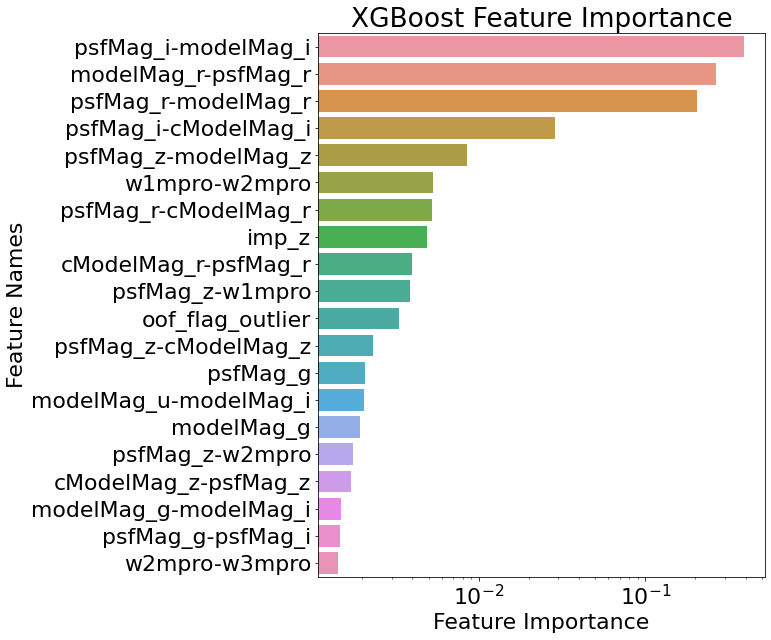

In [23]:
plot_feature_importance(xgb_feat_importance_gal,features,'XGBoost','feat_import_xgb_gal_vs_all.png')

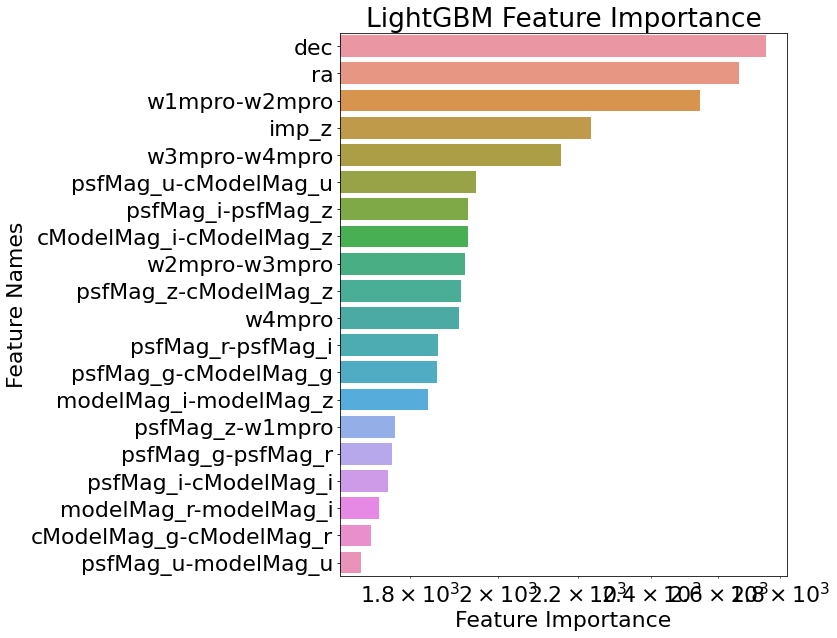

In [24]:
plot_feature_importance(lgb_feat_importance_gal,features,'LightGBM','feat_import_lgb_gal_vs_all.png')

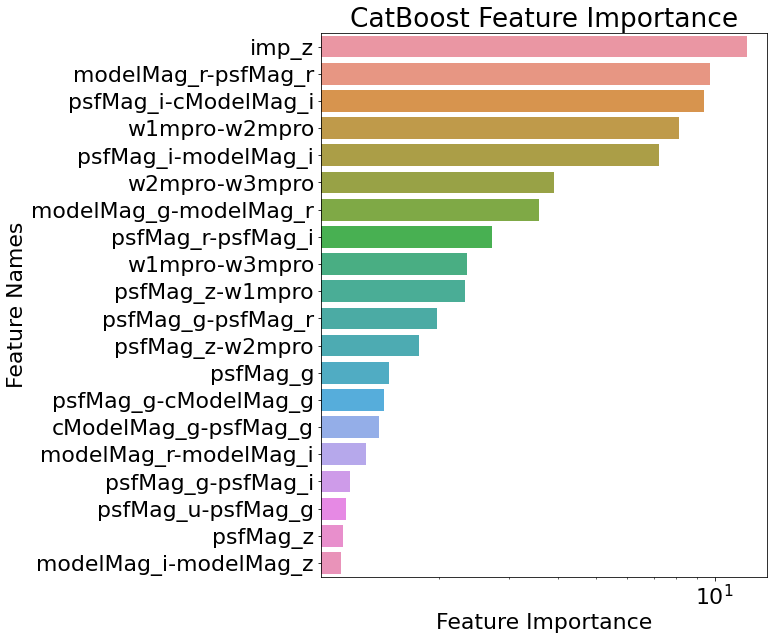

In [25]:
plot_feature_importance(cb_feat_importance_gal,features,'CatBoost','feat_import_cb_gal_vs_all.png')

## QSO vs all

In [34]:
#xgb_qso = flaml_opt_clf(['xgb'], X_train, y_train['is_qso'])

In [22]:
#lgb_qso = flaml_opt_clf(['lgb'], X_train, y_train['is_qso'])

[flaml.automl: 12-05 15:05:24] {1928} INFO - task = classification
[flaml.automl: 12-05 15:05:24] {1930} INFO - Data split method: stratified
[flaml.automl: 12-05 15:05:24] {1934} INFO - Evaluation method: holdout
[flaml.automl: 12-05 15:05:34] {2004} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 12-05 15:05:34] {2056} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 12-05 15:05:34] {2296} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-05 15:05:34] {2410} INFO - Estimated sufficient time budget=324025s. Estimated necessary time budget=324s.
[flaml.automl: 12-05 15:05:34] {2490} INFO -  at 114.3s,	estimator lgbm's best error=0.0229,	best estimator lgbm's best error=0.0229
[flaml.automl: 12-05 15:05:34] {2296} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-05 15:05:34] {2490} INFO -  at 114.5s,	estimator lgbm's best error=0.0229,	best estimator lgbm's best error=0.0229
[flaml.automl: 12-05 15:05:34] {2296} INFO - iteration 2, current le

[flaml.automl: 12-05 15:10:00] {2490} INFO -  at 379.9s,	estimator lgbm's best error=0.0028,	best estimator lgbm's best error=0.0028
[flaml.automl: 12-05 15:10:00] {2296} INFO - iteration 37, current learner lgbm
[flaml.automl: 12-05 15:12:54] {2490} INFO -  at 553.8s,	estimator lgbm's best error=0.0028,	best estimator lgbm's best error=0.0028
[flaml.automl: 12-05 15:12:54] {2296} INFO - iteration 38, current learner lgbm
[flaml.automl: 12-05 15:13:02] {2490} INFO -  at 562.3s,	estimator lgbm's best error=0.0028,	best estimator lgbm's best error=0.0028
[flaml.automl: 12-05 15:13:02] {2296} INFO - iteration 39, current learner lgbm
[flaml.automl: 12-05 15:13:55] {2490} INFO -  at 614.8s,	estimator lgbm's best error=0.0028,	best estimator lgbm's best error=0.0028
[flaml.automl: 12-05 15:13:55] {2296} INFO - iteration 40, current learner lgbm
[flaml.automl: 12-05 15:14:19] {2490} INFO -  at 638.9s,	estimator lgbm's best error=0.0028,	best estimator lgbm's best error=0.0028
[flaml.automl: 

Best estimator: {'lgbm': {'n_estimators': 692, 'num_leaves': 519, 'min_child_samples': 8, 'learning_rate': 0.036154450725483754, 'log_max_bin': 10, 'colsample_bytree': 0.6017096634144301, 'reg_alpha': 0.001975258376030875, 'reg_lambda': 2.0822570450688955, 'FLAML_sample_size': 1563713}}


In [23]:
#cb_qso = flaml_opt_clf(['cb'], X_train, y_train['is_qso'])

[flaml.automl: 12-05 16:22:21] {1928} INFO - task = classification
[flaml.automl: 12-05 16:22:21] {1930} INFO - Data split method: stratified
[flaml.automl: 12-05 16:22:21] {1934} INFO - Evaluation method: holdout
[flaml.automl: 12-05 16:22:31] {2004} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 12-05 16:22:31] {2056} INFO - List of ML learners in AutoML Run: ['catboost']
[flaml.automl: 12-05 16:22:31] {2296} INFO - iteration 0, current learner catboost
[flaml.automl: 12-05 16:22:34] {2410} INFO - Estimated sufficient time budget=3712294s. Estimated necessary time budget=3712s.
[flaml.automl: 12-05 16:22:34] {2490} INFO -  at 121.0s,	estimator catboost's best error=0.0048,	best estimator catboost's best error=0.0048
[flaml.automl: 12-05 16:22:34] {2296} INFO - iteration 1, current learner catboost
[flaml.automl: 12-05 16:22:44] {2490} INFO -  at 131.8s,	estimator catboost's best error=0.0044,	best estimator catboost's best error=0.0044
[flaml.automl: 12-05 16:22:44] {2296} 

[flaml.automl: 12-05 16:35:19] {2490} INFO -  at 886.1s,	estimator catboost's best error=0.0038,	best estimator catboost's best error=0.0038
[flaml.automl: 12-05 16:35:19] {2296} INFO - iteration 35, current learner catboost
[flaml.automl: 12-05 16:38:31] {2490} INFO -  at 1078.7s,	estimator catboost's best error=0.0038,	best estimator catboost's best error=0.0038
[flaml.automl: 12-05 16:38:31] {2296} INFO - iteration 36, current learner catboost
[flaml.automl: 12-05 16:39:04] {2490} INFO -  at 1111.7s,	estimator catboost's best error=0.0038,	best estimator catboost's best error=0.0038
[flaml.automl: 12-05 16:39:04] {2296} INFO - iteration 37, current learner catboost
[flaml.automl: 12-05 16:39:16] {2490} INFO -  at 1123.0s,	estimator catboost's best error=0.0038,	best estimator catboost's best error=0.0038
[flaml.automl: 12-05 16:39:16] {2296} INFO - iteration 38, current learner catboost
[flaml.automl: 12-05 16:39:19] {2490} INFO -  at 1126.6s,	estimator catboost's best error=0.0038,

[flaml.automl: 12-05 16:47:51] {2296} INFO - iteration 71, current learner catboost
[flaml.automl: 12-05 16:47:58] {2490} INFO -  at 1645.7s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 16:47:58] {2296} INFO - iteration 72, current learner catboost
[flaml.automl: 12-05 16:48:28] {2490} INFO -  at 1675.5s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 16:48:28] {2296} INFO - iteration 73, current learner catboost
[flaml.automl: 12-05 16:48:34] {2490} INFO -  at 1681.0s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 16:48:34] {2296} INFO - iteration 74, current learner catboost
[flaml.automl: 12-05 16:48:36] {2490} INFO -  at 1683.7s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 16:48:36] {2296} INFO - iteration 75, current learner catboost
[flaml.autom

[flaml.automl: 12-05 17:01:54] {2490} INFO -  at 2481.5s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 17:01:54] {2296} INFO - iteration 108, current learner catboost
[flaml.automl: 12-05 17:02:07] {2490} INFO -  at 2494.8s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 17:02:07] {2296} INFO - iteration 109, current learner catboost
[flaml.automl: 12-05 17:02:11] {2490} INFO -  at 2498.6s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 17:02:11] {2296} INFO - iteration 110, current learner catboost
[flaml.automl: 12-05 17:03:07] {2490} INFO -  at 2554.7s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 17:03:07] {2296} INFO - iteration 111, current learner catboost
[flaml.automl: 12-05 17:04:35] {2490} INFO -  at 2642.4s,	estimator catboost's best error=0.

[flaml.automl: 12-05 17:19:59] {2296} INFO - iteration 144, current learner catboost
[flaml.automl: 12-05 17:20:03] {2490} INFO -  at 3570.2s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 17:20:03] {2296} INFO - iteration 145, current learner catboost
[flaml.automl: 12-05 17:20:12] {2490} INFO -  at 3579.1s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 17:20:12] {2296} INFO - iteration 146, current learner catboost
[flaml.automl: 12-05 17:21:04] {2490} INFO -  at 3631.3s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 17:21:04] {2296} INFO - iteration 147, current learner catboost
[flaml.automl: 12-05 17:21:27] {2490} INFO -  at 3653.9s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 17:21:27] {2296} INFO - iteration 148, current learner catboost
[flaml.

Best estimator: {'catboost': {'early_stopping_rounds': 10, 'learning_rate': 0.1229120572728312, 'n_estimators': 122, 'FLAML_sample_size': 160000}}


In [26]:
xgb_qso = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.41898802160182846, colsample_bynode=1,
              colsample_bytree=0.4972272561013618, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.009359109522734632,
              max_delta_step=0, max_depth=0, max_leaves=2207,
              min_child_weight=19.88765593000535, missing=-9999.0,
              monotone_constraints='()', n_estimators=1733, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0.1461519451411134,
              reg_lambda=0.35169598803448954, scale_pos_weight=1,
              subsample=0.9462723804220237, tree_method='gpu_hist',
              use_label_encoder=False, validate_parameters=1, verbosity=0)

In [27]:
lgb_qso = lgb.LGBMClassifier(colsample_bytree=0.6017096634144301,
               learning_rate=0.036154450725483754, max_bin=1023,
               min_child_samples=8, n_estimators=692, num_leaves=519,
               reg_alpha=0.001975258376030875, reg_lambda=2.0822570450688955,
               verbose=-1)

In [28]:
cb_qso = CatBoostClassifier(early_stopping_rounds= 10, learning_rate= 0.1229120572728312,
                            n_estimators= 122, task_type = 'GPU', verbose=0)

In [29]:
xgb_pred_qso, xgb_pred_proba_qso, xgb_feat_importance_qso = ml_model(xgb_qso, X_train, y_train, X_test, y_test, 'is_qso')

Classification report: 
               precision    recall  f1-score   support

           0    0.97611   0.96006   0.96802    237263
           1    0.99375   0.99631   0.99503   1511669

    accuracy                        0.99139   1748932
   macro avg    0.98493   0.97819   0.98152   1748932
weighted avg    0.99135   0.99139   0.99136   1748932


 Confusion matrix: 
 [[ 227787    9476]
 [   5576 1506093]]
None


In [30]:
lgb_pred_qso,lgb_pred_proba_qso, lgb_feat_importance_qso = ml_model(lgb_qso, X_train, y_train, X_test, y_test, 'is_qso')

Classification report: 
               precision    recall  f1-score   support

           0    0.97553   0.96112   0.96827    237263
           1    0.99391   0.99622   0.99506   1511669

    accuracy                        0.99146   1748932
   macro avg    0.98472   0.97867   0.98167   1748932
weighted avg    0.99142   0.99146   0.99143   1748932


 Confusion matrix: 
 [[ 228038    9225]
 [   5719 1505950]]
None


In [31]:
cb_pred_qso, cb_pred_proba_qso, cb_feat_importance_qso = ml_model(cb_qso, X_train, y_train, X_test, y_test, 'is_qso')

Classification report: 
               precision    recall  f1-score   support

           0    0.97297   0.95588   0.96435    237263
           1    0.99309   0.99583   0.99446   1511669

    accuracy                        0.99041   1748932
   macro avg    0.98303   0.97586   0.97941   1748932
weighted avg    0.99036   0.99041   0.99038   1748932


 Confusion matrix: 
 [[ 226796   10467]
 [   6301 1505368]]
None


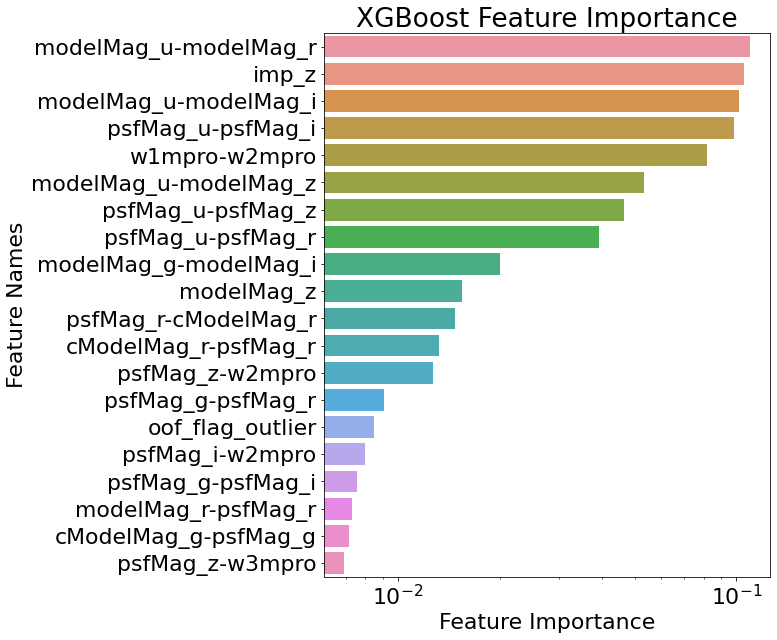

In [32]:
plot_feature_importance(xgb_feat_importance_qso,features,'XGBoost','feat_import_xgb_qso_vs_all.png')

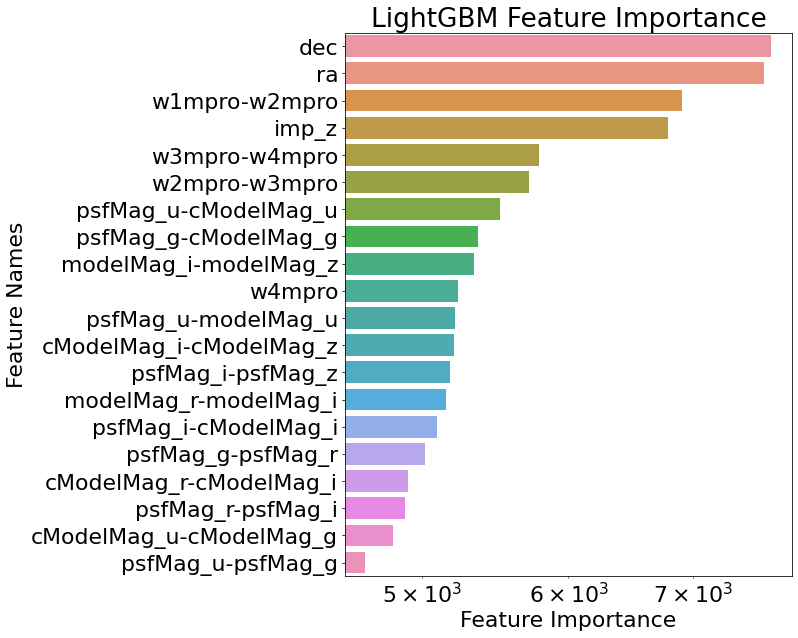

In [33]:
plot_feature_importance(lgb_feat_importance_qso,features,'LightGBM','feat_import_lgb_qso_vs_all.png')

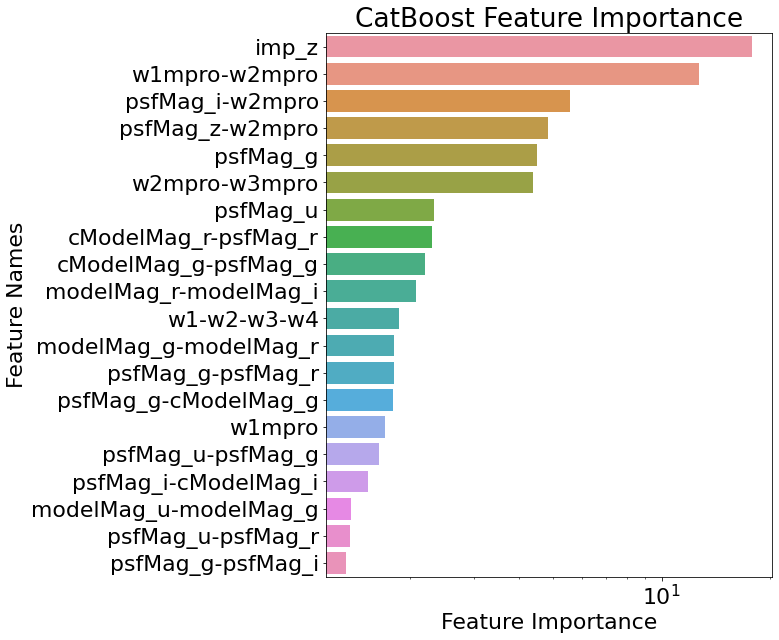

In [34]:
plot_feature_importance(cb_feat_importance_qso,features,'CatBoost','feat_import_cb_qso_vs_all.png')

## Star vs all

In [38]:
#xgb_star = flaml_opt_clf(['xgb'], X_train, y_train['is_star'])

In [12]:
#lgb_star = flaml_opt_clf(['lgb'], X_train, y_train['is_star'])

[flaml.automl: 12-05 17:44:36] {1928} INFO - task = classification
[flaml.automl: 12-05 17:44:36] {1930} INFO - Data split method: stratified
[flaml.automl: 12-05 17:44:36] {1934} INFO - Evaluation method: holdout
[flaml.automl: 12-05 17:44:50] {2004} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 12-05 17:44:50] {2056} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 12-05 17:44:50] {2296} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-05 17:44:50] {2410} INFO - Estimated sufficient time budget=490415s. Estimated necessary time budget=490s.
[flaml.automl: 12-05 17:44:50] {2490} INFO -  at 142.5s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 12-05 17:44:50] {2296} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-05 17:44:50] {2490} INFO -  at 142.8s,	estimator lgbm's best error=0.0248,	best estimator lgbm's best error=0.0248
[flaml.automl: 12-05 17:44:50] {2296} INFO - iteration 2, current le

[flaml.automl: 12-05 17:50:50] {2490} INFO -  at 502.4s,	estimator lgbm's best error=0.0013,	best estimator lgbm's best error=0.0013
[flaml.automl: 12-05 17:50:50] {2296} INFO - iteration 37, current learner lgbm
[flaml.automl: 12-05 17:52:01] {2490} INFO -  at 572.9s,	estimator lgbm's best error=0.0013,	best estimator lgbm's best error=0.0013
[flaml.automl: 12-05 17:52:01] {2296} INFO - iteration 38, current learner lgbm
[flaml.automl: 12-05 17:52:35] {2490} INFO -  at 607.8s,	estimator lgbm's best error=0.0013,	best estimator lgbm's best error=0.0013
[flaml.automl: 12-05 17:52:35] {2296} INFO - iteration 39, current learner lgbm
[flaml.automl: 12-05 17:58:11] {2490} INFO -  at 943.6s,	estimator lgbm's best error=0.0012,	best estimator lgbm's best error=0.0012
[flaml.automl: 12-05 17:58:11] {2296} INFO - iteration 40, current learner lgbm
[flaml.automl: 12-05 17:59:19] {2490} INFO -  at 1011.6s,	estimator lgbm's best error=0.0012,	best estimator lgbm's best error=0.0012
[flaml.automl:

Best estimator: {'lgbm': {'n_estimators': 4054, 'num_leaves': 276, 'min_child_samples': 11, 'learning_rate': 0.0248246268850278, 'log_max_bin': 10, 'colsample_bytree': 0.7547746254097104, 'reg_alpha': 0.025749981001891773, 'reg_lambda': 0.6701686988213098, 'FLAML_sample_size': 1563713}}


In [13]:
#cb_star = flaml_opt_clf(['cb'], X_train, y_train['is_star'])

[flaml.automl: 12-05 19:12:34] {1928} INFO - task = classification
[flaml.automl: 12-05 19:12:34] {1930} INFO - Data split method: stratified
[flaml.automl: 12-05 19:12:34] {1934} INFO - Evaluation method: holdout
[flaml.automl: 12-05 19:12:47] {2004} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 12-05 19:12:47] {2056} INFO - List of ML learners in AutoML Run: ['catboost']
[flaml.automl: 12-05 19:12:47] {2296} INFO - iteration 0, current learner catboost
[flaml.automl: 12-05 19:12:51] {2410} INFO - Estimated sufficient time budget=4822109s. Estimated necessary time budget=4822s.
[flaml.automl: 12-05 19:12:51] {2490} INFO -  at 124.4s,	estimator catboost's best error=0.0040,	best estimator catboost's best error=0.0040
[flaml.automl: 12-05 19:12:51] {2296} INFO - iteration 1, current learner catboost
[flaml.automl: 12-05 19:12:59] {2490} INFO -  at 133.0s,	estimator catboost's best error=0.0037,	best estimator catboost's best error=0.0037
[flaml.automl: 12-05 19:12:59] {2296} 

[flaml.automl: 12-05 19:30:14] {2490} INFO -  at 1167.6s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 19:30:14] {2296} INFO - iteration 35, current learner catboost
[flaml.automl: 12-05 19:31:08] {2490} INFO -  at 1222.2s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 19:31:08] {2296} INFO - iteration 36, current learner catboost
[flaml.automl: 12-05 19:31:17] {2490} INFO -  at 1230.9s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 19:31:17] {2296} INFO - iteration 37, current learner catboost
[flaml.automl: 12-05 19:31:22] {2490} INFO -  at 1236.3s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 19:31:22] {2296} INFO - iteration 38, current learner catboost
[flaml.automl: 12-05 19:31:33] {2490} INFO -  at 1247.1s,	estimator catboost's best error=0.0019

[flaml.automl: 12-05 19:50:58] {2296} INFO - iteration 71, current learner catboost
[flaml.automl: 12-05 19:51:08] {2490} INFO -  at 2422.0s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 19:51:08] {2296} INFO - iteration 72, current learner catboost
[flaml.automl: 12-05 19:51:12] {2490} INFO -  at 2426.2s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 19:51:12] {2296} INFO - iteration 73, current learner catboost
[flaml.automl: 12-05 19:51:16] {2490} INFO -  at 2429.5s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 19:51:16] {2296} INFO - iteration 74, current learner catboost
[flaml.automl: 12-05 19:51:25] {2490} INFO -  at 2438.9s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 19:51:25] {2296} INFO - iteration 75, current learner catboost
[flaml.autom

[flaml.automl: 12-05 20:00:36] {2490} INFO -  at 2989.8s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 20:00:36] {2296} INFO - iteration 108, current learner catboost
[flaml.automl: 12-05 20:01:07] {2490} INFO -  at 3020.6s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 20:01:07] {2296} INFO - iteration 109, current learner catboost
[flaml.automl: 12-05 20:06:10] {2490} INFO -  at 3323.5s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 20:06:10] {2296} INFO - iteration 110, current learner catboost
[flaml.automl: 12-05 20:06:13] {2490} INFO -  at 3326.4s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 20:06:13] {2296} INFO - iteration 111, current learner catboost
[flaml.automl: 12-05 20:06:17] {2490} INFO -  at 3330.4s,	estimator catboost's best error=0.

[flaml.automl: 12-05 20:14:07] {2296} INFO - iteration 144, current learner catboost
[flaml.automl: 12-05 20:17:33] {2490} INFO -  at 4007.1s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 20:17:33] {2296} INFO - iteration 145, current learner catboost
[flaml.automl: 12-05 20:17:59] {2490} INFO -  at 4032.7s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 20:17:59] {2296} INFO - iteration 146, current learner catboost
[flaml.automl: 12-05 20:18:18] {2490} INFO -  at 4051.8s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 20:18:18] {2296} INFO - iteration 147, current learner catboost
[flaml.automl: 12-05 20:19:00] {2490} INFO -  at 4093.8s,	estimator catboost's best error=0.0019,	best estimator catboost's best error=0.0019
[flaml.automl: 12-05 20:19:00] {2296} INFO - iteration 148, current learner catboost
[flaml.

Best estimator: {'catboost': {'early_stopping_rounds': 10, 'learning_rate': 0.08740841428170476, 'n_estimators': 167, 'FLAML_sample_size': 1563713}}


In [35]:
xgb_star = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.7540582998659452,
              max_delta_step=0, max_depth=11, min_child_weight=1,
              missing=-9999.0, monotone_constraints='()', n_estimators=1668,
              n_jobs=-1, num_parallel_tree=1, random_state=24, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=5.0, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [36]:
lgb_star = lgb.LGBMClassifier(colsample_bytree=0.7547746254097104,
               learning_rate=0.0248246268850278, max_bin=1023,
               min_child_samples=11, n_estimators=4054, num_leaves=276,
               reg_alpha=0.025749981001891773, reg_lambda=0.6701686988213098,
               verbose=-1)

In [37]:
cb_star = CatBoostClassifier(early_stopping_rounds= 10, learning_rate= 0.08740841428170476,
                             n_estimators= 167, task_type = 'GPU',verbose=0)

In [38]:
xgb_pred_star, xgb_pred_proba_star, xgb_feat_importance_star = ml_model(xgb_star, X_train, y_train, X_test, y_test, 'is_star')

Classification report: 
               precision    recall  f1-score   support

           0    0.99092   0.97843   0.98463    299936
           1    0.99555   0.99814   0.99684   1448996

    accuracy                        0.99476   1748932
   macro avg    0.99323   0.98828   0.99074   1748932
weighted avg    0.99475   0.99476   0.99475   1748932


 Confusion matrix: 
 [[ 293465    6471]
 [   2689 1446307]]
None


In [39]:
lgb_pred_star,lgb_pred_proba_star, lgb_feat_importance_star = ml_model(lgb_star, X_train, y_train, X_test, y_test, 'is_star')

Classification report: 
               precision    recall  f1-score   support

           0    0.99074   0.98042   0.98556    299936
           1    0.99596   0.99810   0.99703   1448996

    accuracy                        0.99507   1748932
   macro avg    0.99335   0.98926   0.99129   1748932
weighted avg    0.99506   0.99507   0.99506   1748932


 Confusion matrix: 
 [[ 294064    5872]
 [   2748 1446248]]
None


In [40]:
cb_pred_star,cb_pred_proba_star, cb_feat_importance_star = ml_model(cb_star, X_train, y_train, X_test, y_test, 'is_star')

Classification report: 
               precision    recall  f1-score   support

           0    0.98877   0.97635   0.98252    299936
           1    0.99512   0.99770   0.99641   1448996

    accuracy                        0.99404   1748932
   macro avg    0.99194   0.98703   0.98947   1748932
weighted avg    0.99403   0.99404   0.99403   1748932


 Confusion matrix: 
 [[ 292844    7092]
 [   3327 1445669]]
None


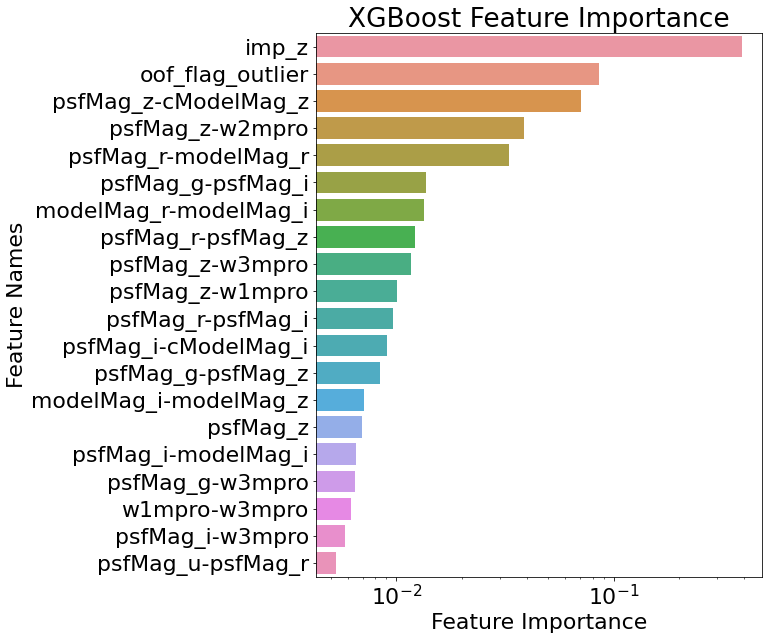

In [41]:
plot_feature_importance(xgb_feat_importance_star,features,'XGBoost','feat_import_xgb_star_vs_all.png')

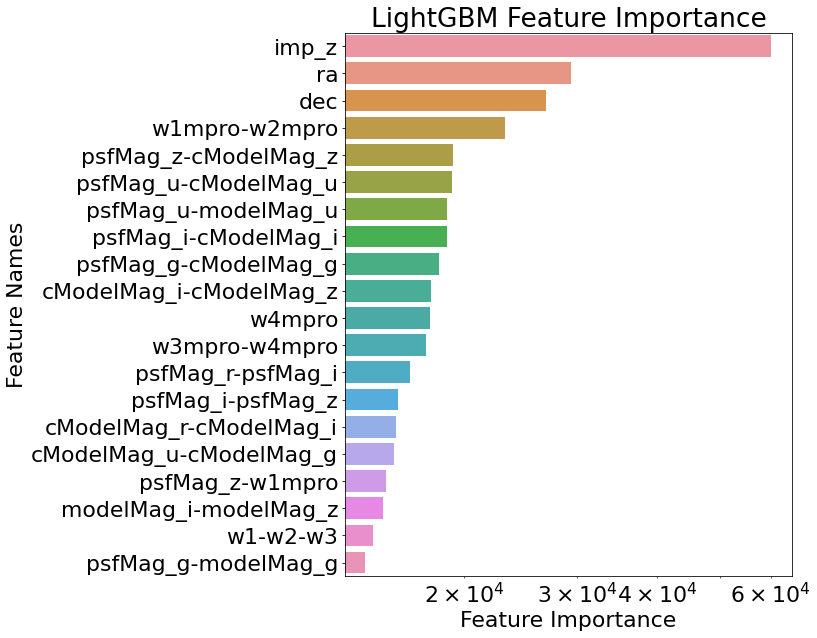

In [42]:
plot_feature_importance(lgb_feat_importance_star,features,'LightGBM','feat_import_lgb_star_vs_all.png')

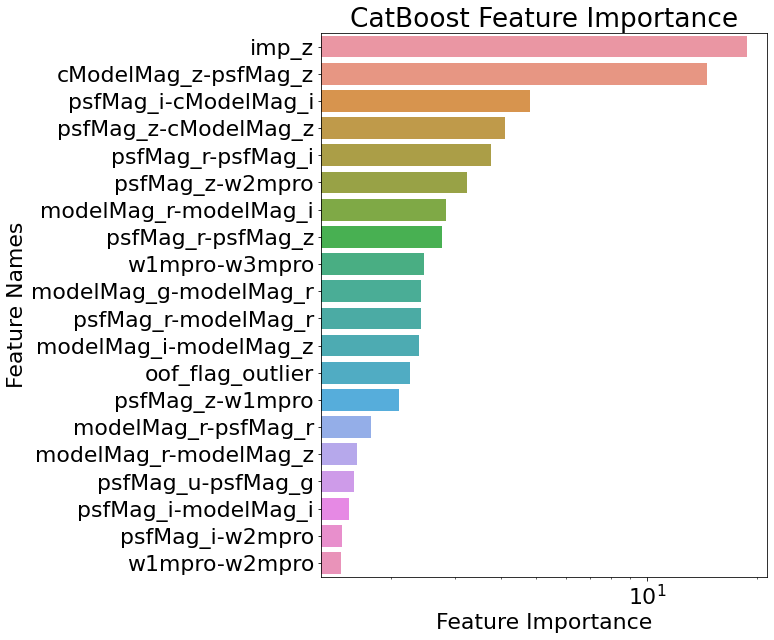

In [43]:
plot_feature_importance(cb_feat_importance_star,features,'CatBoost','feat_import_cb_star_vs_all.png')

## Analysis of the predictions

In [44]:
pd.DataFrame(xgb_pred_proba_gal)[0]

0          0.992523
1          0.999709
2          0.999802
3          0.000234
4          0.000221
             ...   
1748927    0.999842
1748928    0.000108
1748929    0.998699
1748930    0.000950
1748931    0.999682
Name: 0, Length: 1748932, dtype: float32

In [45]:
predictions = pd.DataFrame({'is_gal': xgb_pred_gal, 'is_qso': xgb_pred_qso, 'is_star': xgb_pred_star}, index=y_test.index)
gal_pred_proba = pd.DataFrame({'xgb': pd.DataFrame(xgb_pred_proba_gal, index=y_test.index)[0], 'lgb': pd.DataFrame(lgb_pred_proba_gal, index=y_test.index)[0], 'cb': pd.DataFrame(cb_pred_proba_gal, index=y_test.index)[0]}, index=y_test.index)
qso_pred_proba = pd.DataFrame({'xgb': pd.DataFrame(xgb_pred_proba_qso, index=y_test.index)[0], 'lgb': pd.DataFrame(lgb_pred_proba_qso, index=y_test.index)[0], 'cb': pd.DataFrame(cb_pred_proba_qso, index=y_test.index)[0]}, index=y_test.index)
star_pred_proba = pd.DataFrame({'xgb': pd.DataFrame(xgb_pred_proba_star, index=y_test.index)[0], 'lgb': pd.DataFrame(lgb_pred_proba_star, index=y_test.index)[0], 'cb': pd.DataFrame(cb_pred_proba_star, index=y_test.index)[0]}, index=y_test.index)

In [46]:
predictions['equal_gal_qso']=np.where((predictions['is_gal']== 0) & (predictions['is_qso']==0), True, False)
predictions['equal_gal_star']=np.where((predictions['is_gal']== 0) & (predictions['is_star']==0), True, False)
predictions['equal_qso_star']=np.where((predictions['is_qso']== 0) & (predictions['is_star']==0), True, False)
predictions['equal_all']=np.where((predictions['is_gal']== 1) & (predictions['is_qso']== 1) & (predictions['is_star']==1), True, False)

In [47]:
predictions[predictions['equal_all']==True]

,is_gal,is_qso,is_star,equal_gal_qso,equal_gal_star,equal_qso_star,equal_all
2975255,1,1,1,False,False,False,True
2818725,1,1,1,False,False,False,True
1641279,1,1,1,False,False,False,True
1028963,1,1,1,False,False,False,True
1800922,1,1,1,False,False,False,True
...,...,...,...,...,...,...,...
1062306,1,1,1,False,False,False,True
456093,1,1,1,False,False,False,True
240491,1,1,1,False,False,False,True
2091301,1,1,1,False,False,False,True


In [48]:
predictions[predictions['equal_gal_star']==True]

,is_gal,is_qso,is_star,equal_gal_qso,equal_gal_star,equal_qso_star,equal_all
3461798,0,1,0,False,True,False,False
755310,0,1,0,False,True,False,False
2988399,0,1,0,False,True,False,False
2572655,0,1,0,False,True,False,False
2337579,0,1,0,False,True,False,False
...,...,...,...,...,...,...,...
3402180,0,1,0,False,True,False,False
1215071,0,1,0,False,True,False,False
1802397,0,1,0,False,True,False,False
538458,0,1,0,False,True,False,False


In [49]:
predictions[predictions['equal_qso_star']==True]

,is_gal,is_qso,is_star,equal_gal_qso,equal_gal_star,equal_qso_star,equal_all
466001,1,0,0,False,False,True,False
1740235,1,0,0,False,False,True,False
837347,1,0,0,False,False,True,False
2881189,1,0,0,False,False,True,False
3061954,1,0,0,False,False,True,False
...,...,...,...,...,...,...,...
1495888,1,0,0,False,False,True,False
1837573,1,0,0,False,False,True,False
2403274,1,0,0,False,False,True,False
2784581,1,0,0,False,False,True,False


In [50]:
predictions[predictions['equal_gal_qso']==True]

,is_gal,is_qso,is_star,equal_gal_qso,equal_gal_star,equal_qso_star,equal_all
371962,0,0,1,True,False,False,False
140499,0,0,1,True,False,False,False
3472873,0,0,1,True,False,False,False
2867649,0,0,1,True,False,False,False
3343689,0,0,1,True,False,False,False
...,...,...,...,...,...,...,...
840878,0,0,1,True,False,False,False
2684861,0,0,1,True,False,False,False
425697,0,0,1,True,False,False,False
192540,0,0,1,True,False,False,False


In [51]:
predictions

,is_gal,is_qso,is_star,equal_gal_qso,equal_gal_star,equal_qso_star,equal_all
1021767,0,1,1,False,False,False,False
520095,0,1,1,False,False,False,False
3356694,0,1,1,False,False,False,False
290933,1,1,0,False,False,False,False
1120533,1,1,0,False,False,False,False
...,...,...,...,...,...,...,...
3331278,0,1,1,False,False,False,False
190625,1,1,0,False,False,False,False
1505228,0,1,1,False,False,False,False
3043989,1,1,0,False,False,False,False


In [52]:
l_index = list(predictions['equal_gal_qso'][predictions['equal_gal_qso']==True].index) + list(predictions['equal_gal_star'][predictions['equal_gal_star']==True].index) + list(predictions['equal_qso_star'][predictions['equal_qso_star']==True].index) + list(predictions[predictions['equal_all']==True].index)

In [53]:
len(l_index)

5285

In [54]:
X_test.loc[l_index]

,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,w1mpro,w2mpro,w3mpro,w4mpro,modelMag_u,...,w1mpro-w4mpro,w2mpro-w3mpro,w2mpro-w4mpro,w3mpro-w4mpro,w1-w2-w3,w1-w2-w3-w4,imp_z,oof_flag_outlier,ra,dec
371962,23.311171,22.104271,21.726780,21.077431,20.702070,16.889000,16.375000,12.740,9.119,23.488020,...,7.770,3.635,7.256,3.621,12.226,21.344999,1.737902,0.0,150.446190,32.450342
140499,24.110220,25.413540,22.379641,21.405769,20.502489,14.979000,14.416000,10.920,8.135,23.879681,...,6.844,3.496,6.281,2.785,10.357,18.492001,1.793940,0.0,71.423487,24.944750
3472873,20.704540,19.230160,18.285620,17.846889,17.607519,13.490000,12.641000,9.825,7.500,19.897850,...,5.990,2.816,5.141,2.325,8.976,16.476000,1.180706,0.0,231.664600,55.300626
2867649,22.199680,20.449631,19.261940,18.539310,18.287540,13.758000,13.178000,9.820,6.771,20.622660,...,6.987,3.358,6.407,3.049,9.240,16.011000,1.187518,0.0,329.947110,-0.445644
3343689,22.184000,21.650820,20.609501,19.889771,19.691820,15.185000,14.749000,11.282,8.262,21.914881,...,6.923,3.467,6.487,3.020,10.846,19.108000,1.570376,0.0,192.267570,7.914476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1062306,22.434521,21.945660,21.501949,21.691750,20.799210,16.667000,16.846001,12.761,9.425,22.446760,...,7.242,4.085,7.421,3.336,12.940,22.365000,1.323171,0.0,34.962082,-3.767680
456093,24.245480,24.079020,23.400009,21.007900,20.234480,14.935000,14.970000,12.558,9.058,24.253771,...,5.877,2.412,5.912,3.500,12.593,21.650999,1.307454,1.0,7.277954,22.647644
240491,24.634331,25.114380,20.290150,20.470100,17.974840,13.279000,13.298000,12.357,8.941,24.634661,...,4.338,0.941,4.357,3.416,12.376,21.316999,1.213478,0.0,16.832584,-0.293345
2091301,20.807770,20.177811,19.398569,18.997971,19.159170,15.131000,14.664000,11.932,9.348,19.852209,...,5.783,2.732,5.316,2.584,11.465,20.813000,1.141290,0.0,231.360800,29.822489


In [55]:
y_test.loc[l_index]

,class,is_galaxy,is_qso,is_star
371962,1,1,0,1
140499,2,1,1,0
3472873,1,1,0,1
2867649,1,1,0,1
3343689,1,1,0,1
...,...,...,...,...
1062306,1,1,0,1
456093,0,0,1,1
240491,2,1,1,0
2091301,0,0,1,1


In [56]:
gal_pred_proba.loc[l_index]

,xgb,lgb,cb
371962,0.524341,0.455120,0.572690
140499,0.611479,0.708222,0.860397
3472873,0.545506,0.463939,0.287800
2867649,0.529322,0.623073,0.578537
3343689,0.509351,0.285624,0.440568
...,...,...,...
1062306,0.229981,0.288034,0.335926
456093,0.326261,0.293426,0.113655
240491,0.150600,0.123934,0.180619
2091301,0.436459,0.279097,0.868805


In [57]:
qso_pred_proba.loc[l_index]

,xgb,lgb,cb
371962,0.656283,0.605927,0.495610
140499,0.631581,0.638751,0.098120
3472873,0.500955,0.709346,0.710139
2867649,0.626543,0.399680,0.318941
3343689,0.508843,0.460715,0.735005
...,...,...,...
1062306,0.413919,0.492087,0.198849
456093,0.004785,0.001557,0.007212
240491,0.005876,0.000771,0.000625
2091301,0.340157,0.384765,0.197699


In [58]:
star_pred_proba.loc[l_index]

,xgb,lgb,cb
371962,0.000009,0.000064,0.005827
140499,0.000000,0.000022,0.004539
3472873,0.000000,0.000004,0.001535
2867649,0.000000,0.000009,0.001758
3343689,0.000000,0.000004,0.003369
...,...,...,...
1062306,0.000300,0.008952,0.108799
456093,0.262799,0.656652,0.660511
240491,0.227246,0.961905,0.837108
2091301,0.000000,0.000002,0.000516


### Compilation of the one vs all approach

#### Transforming binary classification into categorical

In [59]:
pred_gal = pd.Series(np.where((predictions['is_gal']== 0) & (predictions['is_qso']==1) & (predictions['is_star']==1), 'GALAXY', 'Other'), index = predictions.index)
pred_gal = pred_gal[pred_gal=='GALAXY']
pred_qso = pd.Series(np.where((predictions['is_gal']== 1) & (predictions['is_qso']==0) & (predictions['is_star']==1), 'QSO', 'Other'), index = predictions.index)
pred_qso = pred_qso[pred_qso=='QSO']
pred_star = pd.Series(np.where((predictions['is_gal']== 1) & (predictions['is_qso']==1) & (predictions['is_star']==0), 'STAR', 'Other'), index = predictions.index)
pred_star = pred_star[pred_star=='STAR']

In [60]:
pred_one_vs_all = pd.Series()
l = [pred_gal, pred_qso, pred_star]
#Append all predictions into one pandas Series
for i in range(len(l)):
    pred_one_vs_all = pred_one_vs_all.append(l[i])

In [61]:
le = sklearn.preprocessing.LabelEncoder()
pred_one_vs_all = pd.Series(le.fit_transform(pred_one_vs_all), index=pred_one_vs_all.index)
print('Labels [0,1,2]: ',le.inverse_transform([0,1,2]))
print('Data encoded.\n')

Labels [0,1,2]:  ['GALAXY' 'QSO' 'STAR']
Data encoded.



In [62]:
len(y_test)-len(pred_one_vs_all)

5283

## Validation of the one vs all predictions (without misclassifications)

In [63]:
one_index = pred_one_vs_all.index.to_list()

In [62]:
xgb_multi = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints='', learning_rate=0.28591333910945194,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=-9999.0,
              monotone_constraints='()', n_estimators=1301, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=24,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [63]:
xgb_pred_one,xgb_pred_one_proba, xgb_feat_importance_one = ml_model(xgb_multi, X_train, y_train, X_test.loc[one_index], y_test.loc[one_index], 'class')

Classification report: 
               precision    recall  f1-score   support

           0    0.99053   0.99582   0.99317   1210676
           1    0.97855   0.96334   0.97088    235393
           2    0.99233   0.98298   0.98763    297611

    accuracy                        0.98924   1743680
   macro avg    0.98714   0.98071   0.98389   1743680
weighted avg    0.98922   0.98924   0.98921   1743680


 Confusion matrix: 
 [[1205614    3450    1612]
 [   7982  226763     648]
 [   3545    1521  292545]]
None


In [64]:
metric_scores(y_test['class'].loc[one_index],pred_one_vs_all)

Classification report: 
               precision    recall  f1-score   support

           0    0.99046   0.99598   0.99321   1210676
           1    0.97903   0.96326   0.97108    235393
           2    0.99260   0.98274   0.98765    297611

    accuracy                        0.98930   1743680
   macro avg    0.98736   0.98066   0.98398   1743680
weighted avg    0.98928   0.98930   0.98927   1743680


 Confusion matrix: 
 [[1205807    3314    1555]
 [   8023  226744     626]
 [   3593    1543  292475]]


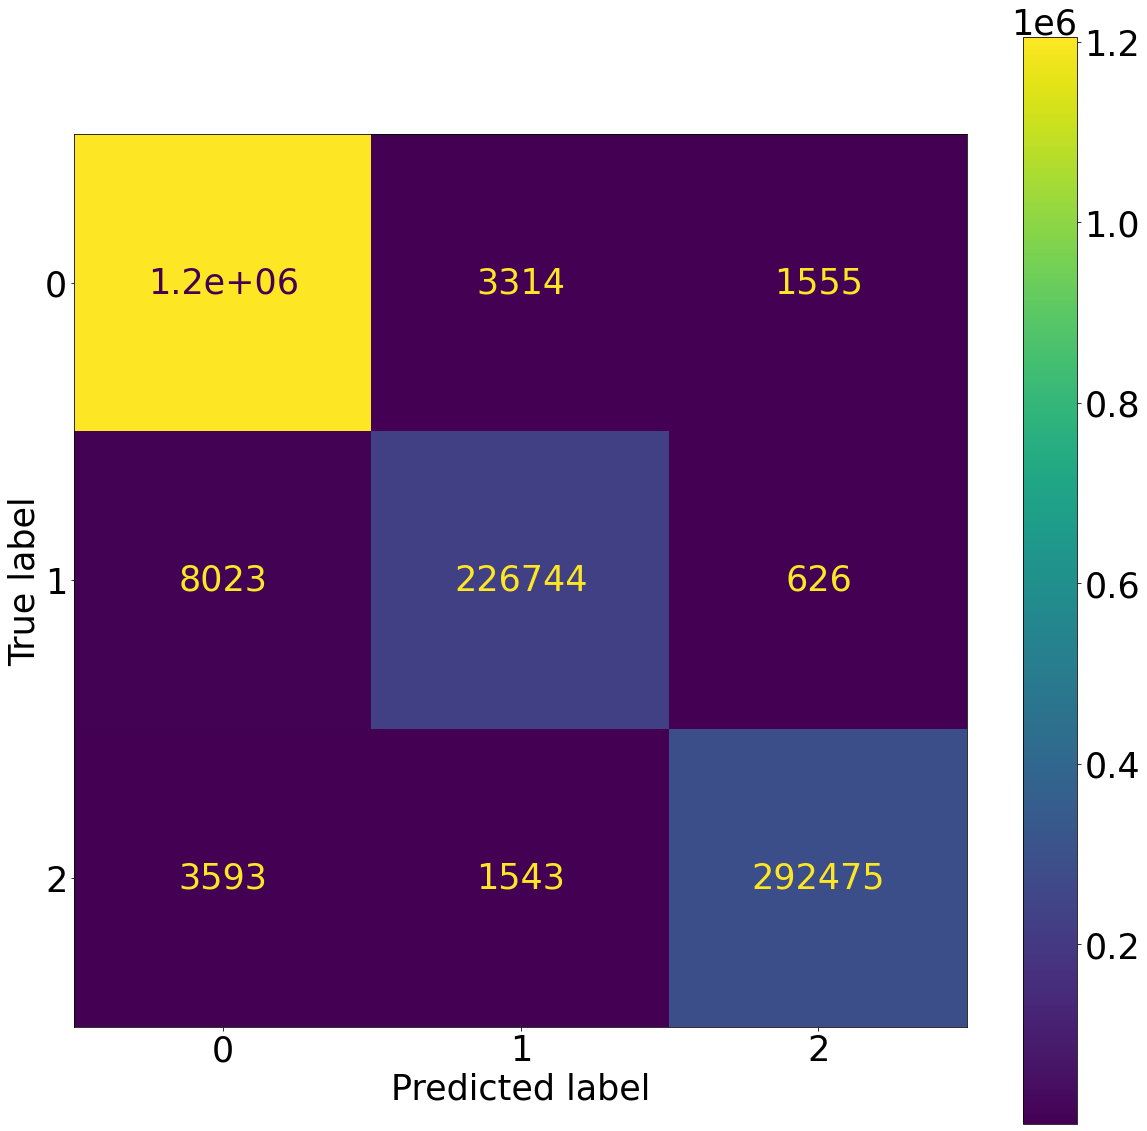

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams.update({'font.size': 35})
cm = confusion_matrix(y_test['class'].loc[one_index],pred_one_vs_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(colorbar='False')

plt.show()

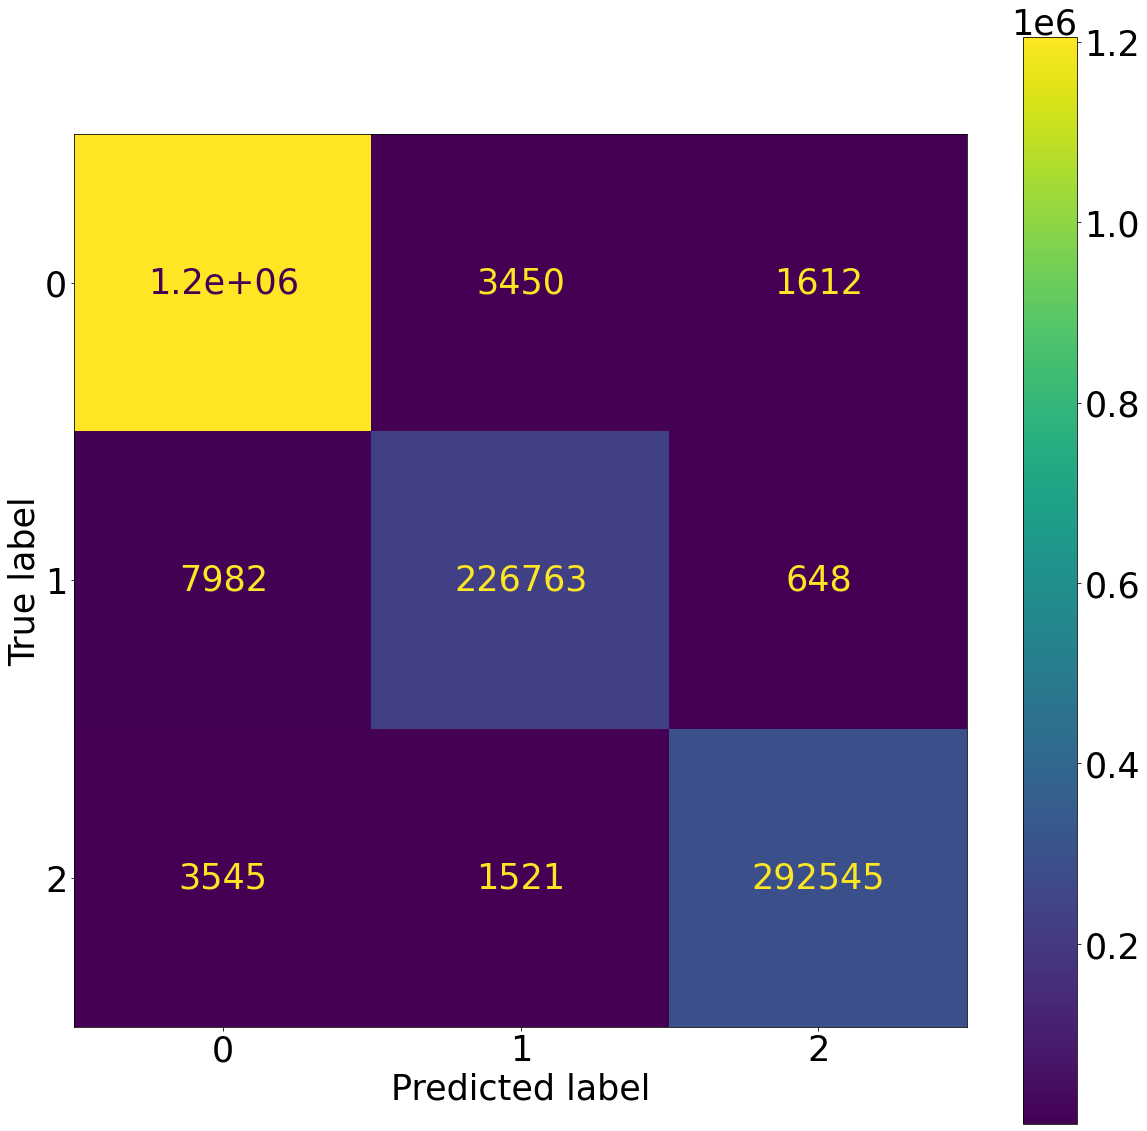

In [80]:
cm = confusion_matrix(y_test['class'].loc[one_index],xgb_pred_one)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

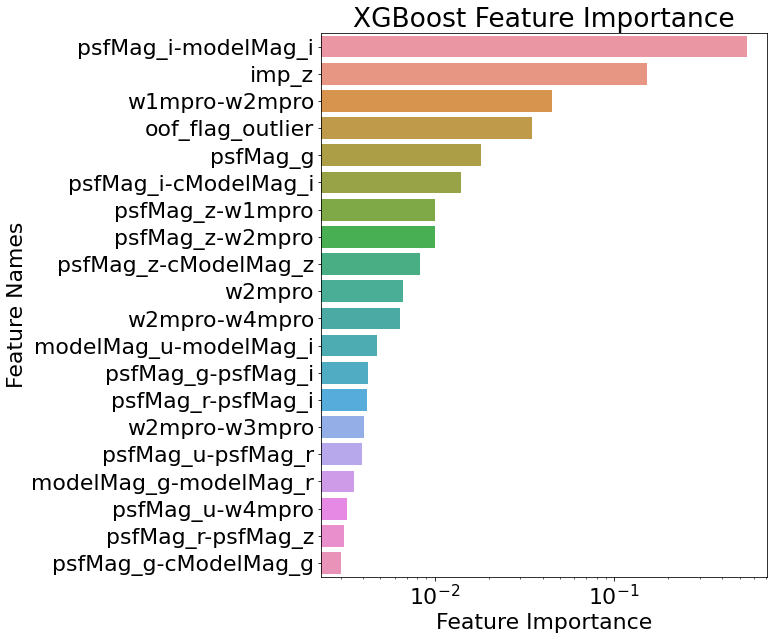

In [85]:
plot_feature_importance(xgb_feat_importance_one,features,'XGBoost','feat_import_xgb_onevsall_clear_preds.png')

## Multiclassifier to correct misclassifications

In [64]:
xgb_multi = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5241738682334621, colsample_bynode=1,
              colsample_bytree=0.671168787703373, gamma=0, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.07438542233856403,
              max_delta_step=0, max_depth=0, max_leaves=605,
              min_child_weight=45.13563288392657, missing=-9999.0,
              monotone_constraints='()', n_estimators=150, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0.0009765625, reg_lambda=0.6112274550663784,
              scale_pos_weight=None, subsample=0.8977673953174077,
              use_label_encoder=False,validate_parameters=1, verbosity=0,
              tree_method='gpu_hist')

In [65]:
cb_multi = CatBoostClassifier(early_stopping_rounds= 11, learning_rate= 0.18865783582261322,
                            n_estimators= 131,verbose=0, task_type="GPU")

In [66]:
lgb_multi = lgb.LGBMClassifier(colsample_bytree=0.9102721130426018,
               learning_rate=0.10233023968742658, max_bin=1023,
               min_child_samples=9, n_estimators=914, num_leaves=26,
               reg_alpha=0.002021902215198225, reg_lambda=22.68747159832061,
               verbose=-1)

In [67]:
xgb_pred_multi,xgb_pred_multi_proba, xgb_feat_importance_multi = ml_model(xgb_multi, X_train, y_train, X_test.loc[l_index], y_test.loc[l_index], 'class')

Classification report: 
               precision    recall  f1-score   support

           0    0.49750   0.51131   0.50431      1946
           1    0.50393   0.46169   0.48189      1527
           2    0.60286   0.62748   0.61493      1812

    accuracy                        0.53680      5285
   macro avg    0.53476   0.53349   0.53371      5285
weighted avg    0.53548   0.53680   0.53576      5285


 Confusion matrix: 
 [[ 995  472  479]
 [ 552  705  270]
 [ 453  222 1137]]
None


In [68]:
lgb_pred_multi,lgb_pred_multi_proba, lgb_feat_importance_multi = ml_model(lgb_multi, X_train, y_train, X_test.loc[l_index], y_test.loc[l_index], 'class')

Classification report: 
               precision    recall  f1-score   support

           0    0.51003   0.50976   0.50989      1946
           1    0.50199   0.49640   0.49918      1527
           2    0.61803   0.62417   0.62109      1812

    accuracy                        0.54513      5285
   macro avg    0.54335   0.54344   0.54339      5285
weighted avg    0.54473   0.54513   0.54492      5285


 Confusion matrix: 
 [[ 992  496  458]
 [ 528  758  241]
 [ 425  256 1131]]
None


In [69]:
cb_pred_multi,cb_pred_multi_proba, cb_feat_importance_multi = ml_model(cb_multi, X_train, y_train, X_test.loc[l_index], y_test.loc[l_index], 'class')

Classification report: 
               precision    recall  f1-score   support

           0    0.45659   0.52158   0.48693      1946
           1    0.45699   0.44532   0.45108      1527
           2    0.57370   0.49834   0.53337      1812

    accuracy                        0.49158      5285
   macro avg    0.49576   0.48841   0.49046      5285
weighted avg    0.49686   0.49158   0.49249      5285


 Confusion matrix: 
 [[1015  486  445]
 [ 621  680  226]
 [ 587  322  903]]
None


In [85]:
xgb_pred_multi = pd.Series(xgb_pred_multi, index = l_index )

## Check if objects have 2MASS and FIRST Data

In [ ]:
X_train_add = pd.concat([X_train,df_check_2MASS_FIRST[['j', 'h', 'k','first_peak', 'first_integrated']].loc[X_train.index]], axis=1, sort=False)

In [ ]:
X_test_add =pd.concat([X_test.loc[l_index],df_check_2MASS_FIRST[['j', 'h', 'k','first_peak', 'first_integrated']].loc[l_index]], axis=1, sort=False)

In [ ]:
l_2MASS = ['j','h','k']
X_train_add2 = create_colours(X_train_add,l_2MASS)
X_test_add2 = create_colours(X_test_add,l_2MASS)

In [ ]:
X_train_add = pd.concat([X_train_add,X_train_add2.reindex(X_train_add.index)], axis=1, sort=False)
X_test_add = pd.concat([X_test_add,X_test_add2.reindex(X_test_add.index)], axis=1, sort=False)

In [ ]:
X_train_add = X_train_add.fillna(-9999.0)

In [ ]:
X_test_add = X_test_add.fillna(-9999.0)

In [ ]:
X_train_add

In [ ]:
X_test_add

### Multiclass model with newer data

In [ ]:
xgb_pred_multi2, xgb_feat_importance_multi2 = ml_model(xgb_multi, X_train_add, y_train, X_test_add, y_test.loc[l_index], 0)

In [ ]:
nfeatures = X_train_add.columns.to_list()
plot_feature_importance(xgb_feat_importance_multi2,nfeatures,'XGBoost')

In [ ]:
sns.histplot(data=X_test_add, x="meta_z2")

In [ ]:
df[['plate','mjd','fiberID']].iloc[l_index]

In [ ]:
df[['ra','dec']].iloc[l_index].to_csv('./Check_data/onevsall_check_coords.txt', index=None)

# Use meta-learner to correct uncertain predictions

In [ ]:
gal_pred_proba
qso_pred_proba
star_pred_proba

In [72]:
gal_pred_proba.loc[l_index]

,xgb,lgb,cb
371962,0.524341,0.455120,0.572690
140499,0.611479,0.708222,0.860397
3472873,0.545506,0.463939,0.287800
2867649,0.529322,0.623073,0.578537
3343689,0.509351,0.285624,0.440568
...,...,...,...
1062306,0.229981,0.288034,0.335926
456093,0.326261,0.293426,0.113655
240491,0.150600,0.123934,0.180619
2091301,0.436459,0.279097,0.868805


In [76]:
qso_pred_proba.loc[l_index]

,xgb,lgb,cb
371962,0.656283,0.605927,0.495610
140499,0.631581,0.638751,0.098120
3472873,0.500955,0.709346,0.710139
2867649,0.626543,0.399680,0.318941
3343689,0.508843,0.460715,0.735005
...,...,...,...
1062306,0.413919,0.492087,0.198849
456093,0.004785,0.001557,0.007212
240491,0.005876,0.000771,0.000625
2091301,0.340157,0.384765,0.197699


In [81]:
one_predictions = pd.merge(gal_pred_proba, qso_pred_proba, left_index=True, right_index=True)
one_predictions = pd.merge(one_predictions, star_pred_proba, left_index=True, right_index=True)
one_predictions = pd.merge(one_predictions, y_test['class'], left_index=True, right_index=True)

In [84]:
one_predictions.columns

Index(['xgb_x', 'lgb_x', 'cb_x', 'xgb_y', 'lgb_y', 'cb_y', 'xgb', 'lgb', 'cb',
       'class'],
      dtype='object')

In [83]:
#one_predictions.to_parquet('./Data/one_vs_all_preds.parquet')

In [87]:
one_predictions[['xgb_x', 'lgb_x', 'cb_x', 'xgb_y', 'lgb_y', 'cb_y', 'xgb', 'lgb', 'cb']].loc[l_index]

,xgb_x,lgb_x,cb_x,xgb_y,lgb_y,cb_y,xgb,lgb,cb
371962,0.524341,0.455120,0.572690,0.656283,0.605927,0.495610,0.000009,0.000064,0.005827
140499,0.611479,0.708222,0.860397,0.631581,0.638751,0.098120,0.000000,0.000022,0.004539
3472873,0.545506,0.463939,0.287800,0.500955,0.709346,0.710139,0.000000,0.000004,0.001535
2867649,0.529322,0.623073,0.578537,0.626543,0.399680,0.318941,0.000000,0.000009,0.001758
3343689,0.509351,0.285624,0.440568,0.508843,0.460715,0.735005,0.000000,0.000004,0.003369
...,...,...,...,...,...,...,...,...,...
1062306,0.229981,0.288034,0.335926,0.413919,0.492087,0.198849,0.000300,0.008952,0.108799
456093,0.326261,0.293426,0.113655,0.004785,0.001557,0.007212,0.262799,0.656652,0.660511
240491,0.150600,0.123934,0.180619,0.005876,0.000771,0.000625,0.227246,0.961905,0.837108
2091301,0.436459,0.279097,0.868805,0.340157,0.384765,0.197699,0.000000,0.000002,0.000516


In [154]:
X_train_one = one_predictions[['xgb_x', 'lgb_x', 'cb_x', 'xgb_y', 'lgb_y', 'cb_y', 'xgb', 'lgb', 'cb']].drop(l_index)
y_train_one = one_predictions[['class']].drop(l_index)
y_train_one = y_train_one['class']

X_test_one = one_predictions[['xgb_x', 'lgb_x', 'cb_x', 'xgb_y', 'lgb_y', 'cb_y', 'xgb', 'lgb', 'cb']].loc[l_index]
y_test_one = one_predictions[['class']].loc[l_index]
y_test_one = y_test_one['class']
y_test_one = y_test_one[~y_test_one.index.duplicated(keep='first')]


In [102]:
meta_automl = flaml_opt_clf([], X_train_one, y_train_one)

[flaml.automl: 12-08 00:25:36] {1943} INFO - task = classification
[flaml.automl: 12-08 00:25:36] {1945} INFO - Data split method: stratified
[flaml.automl: 12-08 00:25:36] {1949} INFO - Evaluation method: holdout
[flaml.automl: 12-08 00:25:38] {2019} INFO - Minimizing error metric: log_loss
[flaml.automl: 12-08 00:25:38] {2071} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 12-08 00:25:38] {2311} INFO - iteration 0, current learner lgbm
[flaml.automl: 12-08 00:25:38] {2425} INFO - Estimated sufficient time budget=157721s. Estimated necessary time budget=3872s.
[flaml.automl: 12-08 00:25:39] {2505} INFO -  at 10.0s,	estimator lgbm's best error=0.3847,	best estimator lgbm's best error=0.3847
[flaml.automl: 12-08 00:25:39] {2311} INFO - iteration 1, current learner lgbm
[flaml.automl: 12-08 00:25:39] {2505} INFO -  at 10.2s,	estimator lgbm's best error=0.3847,	best estimator lgbm's best error=0.3847
[

[flaml.automl: 12-08 00:25:45] {2311} INFO - iteration 36, current learner extra_tree
[flaml.automl: 12-08 00:25:46] {2505} INFO -  at 17.1s,	estimator extra_tree's best error=0.0491,	best estimator lgbm's best error=0.0420
[flaml.automl: 12-08 00:25:46] {2311} INFO - iteration 37, current learner rf
[flaml.automl: 12-08 00:25:46] {2505} INFO -  at 17.5s,	estimator rf's best error=0.0493,	best estimator lgbm's best error=0.0420
[flaml.automl: 12-08 00:25:46] {2311} INFO - iteration 38, current learner xgboost
[flaml.automl: 12-08 00:25:46] {2505} INFO -  at 17.6s,	estimator xgboost's best error=0.0433,	best estimator lgbm's best error=0.0420
[flaml.automl: 12-08 00:25:46] {2311} INFO - iteration 39, current learner lgbm
[flaml.automl: 12-08 00:25:46] {2505} INFO -  at 17.9s,	estimator lgbm's best error=0.0420,	best estimator lgbm's best error=0.0420
[flaml.automl: 12-08 00:25:46] {2311} INFO - iteration 40, current learner xgboost
[flaml.automl: 12-08 00:25:46] {2505} INFO -  at 18.0s,

[flaml.automl: 12-08 00:26:26] {2311} INFO - iteration 74, current learner xgb_limitdepth
[flaml.automl: 12-08 00:26:26] {2505} INFO -  at 57.9s,	estimator xgb_limitdepth's best error=0.0523,	best estimator lgbm's best error=0.0413
[flaml.automl: 12-08 00:26:26] {2311} INFO - iteration 75, current learner xgboost
[flaml.automl: 12-08 00:26:27] {2505} INFO -  at 59.0s,	estimator xgboost's best error=0.0423,	best estimator lgbm's best error=0.0413
[flaml.automl: 12-08 00:26:27] {2311} INFO - iteration 76, current learner xgb_limitdepth
[flaml.automl: 12-08 00:26:28] {2505} INFO -  at 59.5s,	estimator xgb_limitdepth's best error=0.0523,	best estimator lgbm's best error=0.0413
[flaml.automl: 12-08 00:26:28] {2311} INFO - iteration 77, current learner lgbm
[flaml.automl: 12-08 00:26:30] {2505} INFO -  at 61.9s,	estimator lgbm's best error=0.0413,	best estimator lgbm's best error=0.0413
[flaml.automl: 12-08 00:26:30] {2311} INFO - iteration 78, current learner lgbm
[flaml.automl: 12-08 00:26

[flaml.automl: 12-08 00:26:57] {2311} INFO - iteration 111, current learner extra_tree
[flaml.automl: 12-08 00:26:57] {2505} INFO -  at 88.9s,	estimator extra_tree's best error=0.0433,	best estimator lgbm's best error=0.0413
[flaml.automl: 12-08 00:26:57] {2311} INFO - iteration 112, current learner lgbm
[flaml.automl: 12-08 00:27:02] {2505} INFO -  at 93.5s,	estimator lgbm's best error=0.0413,	best estimator lgbm's best error=0.0413
[flaml.automl: 12-08 00:27:02] {2311} INFO - iteration 113, current learner extra_tree
[flaml.automl: 12-08 00:27:05] {2505} INFO -  at 96.1s,	estimator extra_tree's best error=0.0424,	best estimator lgbm's best error=0.0413
[flaml.automl: 12-08 00:27:05] {2311} INFO - iteration 114, current learner extra_tree
[flaml.automl: 12-08 00:27:08] {2505} INFO -  at 99.7s,	estimator extra_tree's best error=0.0424,	best estimator lgbm's best error=0.0413
[flaml.automl: 12-08 00:27:08] {2311} INFO - iteration 115, current learner lrl1
[flaml.automl: 12-08 00:27:09] 

[flaml.automl: 12-08 00:29:12] {2311} INFO - iteration 149, current learner lgbm
[flaml.automl: 12-08 00:29:30] {2505} INFO -  at 241.2s,	estimator lgbm's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:29:30] {2311} INFO - iteration 150, current learner lgbm
[flaml.automl: 12-08 00:29:31] {2505} INFO -  at 242.6s,	estimator lgbm's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:29:31] {2311} INFO - iteration 151, current learner lgbm
[flaml.automl: 12-08 00:29:58] {2505} INFO -  at 270.0s,	estimator lgbm's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:29:58] {2311} INFO - iteration 152, current learner lgbm
[flaml.automl: 12-08 00:29:59] {2505} INFO -  at 271.0s,	estimator lgbm's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:29:59] {2311} INFO - iteration 153, current learner lgbm
[flaml.automl: 12-08 00:30:33] {2505} INFO -  at 304.7s,	estima

[flaml.automl: 12-08 00:38:16] {2505} INFO -  at 767.3s,	estimator xgboost's best error=0.0413,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:38:16] {2311} INFO - iteration 188, current learner rf
[flaml.automl: 12-08 00:38:40] {2505} INFO -  at 791.5s,	estimator rf's best error=0.0421,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:38:40] {2311} INFO - iteration 189, current learner extra_tree
[flaml.automl: 12-08 00:38:42] {2505} INFO -  at 793.6s,	estimator extra_tree's best error=0.0420,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:38:42] {2311} INFO - iteration 190, current learner lgbm
[flaml.automl: 12-08 00:38:53] {2505} INFO -  at 804.9s,	estimator lgbm's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:38:53] {2311} INFO - iteration 191, current learner rf
[flaml.automl: 12-08 00:39:16] {2505} INFO -  at 827.8s,	estimator rf's best error=0.0421,	best estimator lgbm's best error=0.0411
[fla

[flaml.automl: 12-08 00:52:55] {2505} INFO -  at 1646.2s,	estimator lrl1's best error=0.0526,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:52:55] {2311} INFO - iteration 225, current learner xgb_limitdepth
[flaml.automl: 12-08 00:54:48] {2505} INFO -  at 1759.3s,	estimator xgb_limitdepth's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:54:48] {2311} INFO - iteration 226, current learner lgbm
[flaml.automl: 12-08 00:55:05] {2505} INFO -  at 1776.4s,	estimator lgbm's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:55:05] {2311} INFO - iteration 227, current learner lgbm
[flaml.automl: 12-08 00:55:15] {2505} INFO -  at 1786.8s,	estimator lgbm's best error=0.0411,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 00:55:15] {2311} INFO - iteration 228, current learner catboost
[flaml.automl: 12-08 00:55:31] {2505} INFO -  at 1802.3s,	estimator catboost's best error=0.0414,	best estimator lgb

[flaml.automl: 12-08 01:34:48] {2505} INFO -  at 4159.1s,	estimator extra_tree's best error=0.0416,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 01:34:48] {2311} INFO - iteration 262, current learner extra_tree
[flaml.automl: 12-08 01:34:53] {2505} INFO -  at 4164.3s,	estimator extra_tree's best error=0.0416,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 01:34:53] {2311} INFO - iteration 263, current learner extra_tree
[flaml.automl: 12-08 01:35:03] {2505} INFO -  at 4174.6s,	estimator extra_tree's best error=0.0413,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 01:35:03] {2311} INFO - iteration 264, current learner extra_tree
[flaml.automl: 12-08 01:35:14] {2505} INFO -  at 4185.8s,	estimator extra_tree's best error=0.0413,	best estimator lgbm's best error=0.0411
[flaml.automl: 12-08 01:35:14] {2311} INFO - iteration 265, current learner extra_tree
[flaml.automl: 12-08 01:35:19] {2505} INFO -  at 4191.1s,	estimator extra_tree's best error=

Best estimator: {'lgbm': {'n_estimators': 103, 'num_leaves': 38, 'min_child_samples': 18, 'learning_rate': 0.1032373221027049, 'log_max_bin': 10, 'colsample_bytree': 1.0, 'reg_alpha': 0.019732117320210126, 'reg_lambda': 0.24956851428840968, 'FLAML_sample_size': 1569284}, 'rf': {'n_estimators': 4, 'max_features': 0.5408182794922812, 'max_leaves': 52, 'criterion': 'entropy', 'FLAML_sample_size': 1569284}, 'catboost': {'early_stopping_rounds': 10, 'learning_rate': 0.0152400386515256, 'n_estimators': 805, 'FLAML_sample_size': 1569284}, 'xgboost': {'n_estimators': 559, 'max_leaves': 4, 'min_child_weight': 41.88202402302021, 'learning_rate': 0.22584285563312778, 'subsample': 0.9097821361436215, 'colsample_bylevel': 0.8329036448094694, 'colsample_bytree': 0.8904651746776476, 'reg_alpha': 0.0011600546402556703, 'reg_lambda': 0.026375114929932792, 'FLAML_sample_size': 1569284}, 'extra_tree': {'n_estimators': 15, 'max_features': 0.5846184886292357, 'max_leaves': 1351, 'criterion': 'entropy', 'FL

In [108]:
meta_automl= lgb.LGBMClassifier(learning_rate=0.1032373221027049, max_bin=1023,
               min_child_samples=18, n_estimators=103, num_leaves=38,
               reg_alpha=0.019732117320210126, reg_lambda=0.24956851428840968,
               verbose=-1, random_state=0)

In [109]:
meta_automl.fit(X_train_one,y_train_one)

LGBMClassifier(learning_rate=0.1032373221027049, max_bin=1023,
               min_child_samples=18, n_estimators=103, num_leaves=38,
               random_state=0, reg_alpha=0.019732117320210126,
               reg_lambda=0.24956851428840968, verbose=-1)

In [151]:
meta_preds = meta_automl.predict(X_test_one)
meta_preds = pd.Series(meta_preds, index=X_test_one.index)
meta_preds = meta_preds[~meta_preds.index.duplicated(keep='first')]

In [152]:
meta_preds_proba = meta_automl.predict_proba(X_test_one)

In [155]:
metric_scores(y_test_one,meta_preds)

Classification report: 
               precision    recall  f1-score   support

           0    0.58322   0.45015   0.50812      1946
           1    0.54974   0.56525   0.55739      1525
           2    0.62133   0.75883   0.68323      1812

    accuracy                        0.58925      5283
   macro avg    0.58477   0.59141   0.58291      5283
weighted avg    0.58663   0.58925   0.58240      5283


 Confusion matrix: 
 [[ 876  514  556]
 [ 381  862  282]
 [ 245  192 1375]]


In [159]:
meta_preds_proba = pd.DataFrame(meta_preds_proba)b

In [160]:
meta_preds_proba

,0,1,2
0,0.354819,0.633518,0.011663
1,0.409261,0.586959,0.003780
2,0.456641,0.541742,0.001617
3,0.526190,0.471314,0.002497
4,0.470359,0.527194,0.002447
...,...,...,...
5280,0.317623,0.524653,0.157724
5281,0.397423,0.012529,0.590048
5282,0.178771,0.009478,0.811751
5283,0.495243,0.503129,0.001628


# Compilation of the one vs all predictions and multiclassification predictions

In [156]:
final_preds = pred_one_vs_all.append(pd.Series(meta_preds))

In [157]:
len(y_test)-len(final_preds)

0

In [158]:
metric_scores(y_test['class'].reindex(final_preds.index),final_preds)

Classification report: 
               precision    recall  f1-score   support

           0    0.99007   0.99504   0.99255   1211733
           1    0.97541   0.96135   0.96833    237263
           2    0.98994   0.98113   0.98552    299936

    accuracy                        0.98809   1748932
   macro avg    0.98514   0.97917   0.98213   1748932
weighted avg    0.98806   0.98809   0.98806   1748932


 Confusion matrix: 
 [[1205725    3942    2066]
 [   8246  228093     924]
 [   3852    1808  294276]]
